# Hospital Readmission

## Background

WellnessWorks is a healthcare company specializing in providing comprehensive health
services, including patient care, diagnostics, and preventive health measures. They aim to
leverage machine learning techniques to predict patient readmissions, improve patient outcomes,
and optimize hospital operations.

You have been hired as a Junior Data Analyst by Blink Health Solutions, the IT partner of
WellnessWorks. Blink Health wants you to investigate machine learning and its impact on
healthcare analytics. Additionally, you are required to develop a machine learning model for
WellnessWorks that can predict the likelihood of patient readmissions based on historical patient
data.

## Dataset

* Original Source: [Kaggle/datasets/dubradave/hospital-readmissions](https://kaggle.com/datasets/dubradave/hospital-readmissions)
* Import Source: [HuggingFace/datasets/prabinpanta0/genki_hospital](https://huggingface.co/datasets/prabinpanta0/genki_hospital)

## Import Nessecery packages

In [82]:
import joblib
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from huggingface_hub import notebook_login
import huggingface_hub as hf
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, log_loss, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
# import legend
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline


from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt


## Loading the dataset

In [83]:
# Load the data
df = pd.read_csv("hf://datasets/prabinpanta0/genki_hospital/hospital_readmissions.csv")

In [84]:
df.head()

age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 8                72             1             18   
1  [70-80)                 3                34             2             13   
2  [50-60)                 5                45             0             18   
3  [70-80)                 2                36             0             12   
4  [60-70)                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
0             2            0            0           Missing  Circulatory   
1             0            0            0             Other        Other   
2             0            0            0           Missing  Circulatory   
3             1            0            0           Missing  Circulatory   
4             0            0            0  InternalMedicine        Other   

        diag_2       diag_3 glucose_test A1Ctest change diabetes_med  \
0  Respiratory        Other           no      no     no          yes   
1        Other        Other           no      no     no          yes   
2  Circulatory  Circulatory           no      no    yes          yes   
3        Other     Diabetes           no      no    yes          yes   
4  Circulatory  Respiratory           no      no     no          yes   

  readmitted  
0         no  
1         no  
2        yes  
3        yes  
4         no

In [85]:
df.columns


Index(['age', 'time_in_hospital', 'n_lab_procedures', 'n_procedures',
       'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test',
       'A1Ctest', 'change', 'diabetes_med', 'readmitted'],
      dtype='object')

## Data

10 years of patient information:

Information in the file

- "age" - age bracket of the patient
- "time_in_hospital" - days (from 1 to 14)
- "n_procedures" - number of procedures performed during the hospital stay
- "n_lab_procedures" - number of laboratory procedures performed during the hospital stay
- "n_medications" - number of medications administered during the hospital stay
- "n_outpatient" - number of outpatient visits in the year before a hospital stay
- "n_inpatient" - number of inpatient visits in the year before the hospital stay
- "n_emergency" - number of visits to the emergency room in the year before the hospital stay
- "medical_specialty" - the specialty of the admitting physician
- "diag_1" - primary diagnosis (Circulatory, Respiratory, Digestive, etc.)
- "diag_2" - secondary diagnosis
- "diag_3" - additional secondary diagnosis
- "glucose_test" - whether the glucose serum came out as high (> 200), normal, or not performed
- "A1Ctest" - whether the A1C level of the patient came out as high (> 7%), normal, or not performed
- "change" - whether there was a change in the diabetes medication ('yes' or 'no')
- "diabetes_med" - whether a diabetes medication was prescribed ('yes' or 'no')
- "readmitted" - if the patient was readmitted at the hospital ('yes' or 'no')

In [86]:
# Summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

## Data Cleaning

### renaming some columns

In [87]:
#renaming some columns

df.rename(columns={'diag_1':'primary_diagnosis','diag_2':'sec_diagnosis',
                       'diag_3':'additional_sec_diag','change':'med_change','A1Ctest':'HbA1ctest'},inplace=True)

df.head()

age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 8                72             1             18   
1  [70-80)                 3                34             2             13   
2  [50-60)                 5                45             0             18   
3  [70-80)                 2                36             0             12   
4  [60-70)                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty primary_diagnosis  \
0             2            0            0           Missing       Circulatory   
1             0            0            0             Other             Other   
2             0            0            0           Missing       Circulatory   
3             1            0            0           Missing       Circulatory   
4             0            0            0  InternalMedicine             Other   

  sec_diagnosis additional_sec_diag glucose_test HbA1ctest med_change  \
0   Respiratory               Other           no        no         no   
1         Other               Other           no        no         no   
2   Circulatory         Circulatory           no        no        yes   
3         Other            Diabetes           no        no        yes   
4   Circulatory         Respiratory           no        no         no   

  diabetes_med readmitted  
0          yes         no  
1          yes         no  
2          yes        yes  
3          yes        yes  
4          yes         no

### Converting the age column to categorical data

In [88]:
#converting age column to categorical data
#checking for the unique values in the age column
print(df['age'].unique())

#creating a new column called age_cat
df['age_cat'] = df['age'].replace({'[70-80)':'senior-old age',
                                           '[50-60)':'late-middle age','[60-70)':'mid-old age',
                                           '[40-50)':'early-middle age','[80-90)':'very senior-old','[90-100)':'centenarians'})

print('\n')
#converting column type to categorical data type
df['age_cat'] = df['age_cat'].astype('category')
print('dtype :',df['age_cat'].dtype)

#viewing age and age_cat columns
df[['age','age_cat']]

['[70-80)' '[50-60)' '[60-70)' '[40-50)' '[80-90)' '[90-100)']


dtype : category


age          age_cat
0      [70-80)   senior-old age
1      [70-80)   senior-old age
2      [50-60)  late-middle age
3      [70-80)   senior-old age
4      [60-70)      mid-old age
...        ...              ...
24995  [80-90)  very senior-old
24996  [80-90)  very senior-old
24997  [70-80)   senior-old age
24998  [70-80)   senior-old age
24999  [50-60)  late-middle age

[25000 rows x 2 columns]

### drop age column

In [89]:
#drop age column
df.drop('age', axis=1, inplace=True)

#changing data type to the correct data type
# Columns to be converted to categorical datatype
cols_to_convert = ['medical_specialty', 'primary_diagnosis', 'sec_diagnosis', 'additional_sec_diag', 'glucose_test', 'HbA1ctest', 'med_change', 'diabetes_med', 'readmitted']

# Convert columns to categorical datatype
df[cols_to_convert] = df[cols_to_convert].astype('category')
#checking data type
df.dtypes

time_in_hospital          int64
n_lab_procedures          int64
n_procedures              int64
n_medications             int64
n_outpatient              int64
n_inpatient               int64
n_emergency               int64
medical_specialty      category
primary_diagnosis      category
sec_diagnosis          category
additional_sec_diag    category
glucose_test           category
HbA1ctest              category
med_change             category
diabetes_med           category
readmitted             category
age_cat                category
dtype: object

The dataset contained 2500 rows and 17 columns, and these were what I did to the columns:

- There were no missing or duplicates data in the dataframe.
- The columns named diag_1 ,diag_2,diag_3,change,A1Ctest, were renamed as primary_diagnosis ,sec_diagnos ,additional_sec_diag ,med_change , HbA1ctest respectively
- For the age column although the wrong categorization done already couldn't be corrected, the various age categories named as [70-80), [50-60),[60-70), [40-50), [80-90),[90-100), were renamed as senior-old age, late-middle age , mid-oldd-age, early-middle age, very senior-old,centenarians respectively.
- The data type of these rows (medical_specialty, primary_diagnosis , sec_diagnosis, additional_sec_diag, glucose_test, HbA1ctest, med_change, diabetes_med, readmitted)were converted to categorical data type

At the end there was 2500 rows and 17 columns .

## DATA ANALYSIS

In [90]:
# Complete analysis of the dataset
df.describe()


time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
count          25000.00          25000.00      25000.00       25000.00   
mean               4.45             43.24          1.35          16.25   
std                3.00             19.82          1.72           8.06   
min                1.00              1.00          0.00           1.00   
25%                2.00             31.00          0.00          11.00   
50%                4.00             44.00          1.00          15.00   
75%                6.00             57.00          2.00          20.00   
max               14.00            113.00          6.00          79.00   

       n_outpatient  n_inpatient  n_emergency  
count      25000.00     25000.00     25000.00  
mean           0.37         0.62         0.19  
std            1.20         1.18         0.89  
min            0.00         0.00         0.00  
25%            0.00         0.00         0.00  
50%            0.00         0.00         0.00  
75%            0.00         1.00         0.00  
max           33.00        15.00        64.00

In [91]:
#describing the categorical columns
df.describe(exclude=[np.number])

medical_specialty primary_diagnosis sec_diagnosis additional_sec_diag  \
count              25000             25000         25000               25000   
unique                 7                 8             8                   8   
top              Missing       Circulatory         Other               Other   
freq               12382              7824          9056                9107   

       glucose_test HbA1ctest med_change diabetes_med readmitted  \
count         25000     25000      25000        25000      25000   
unique            3         3          2            2          2   
top              no        no         no          yes         no   
freq          23625     20938      13497        19228      13246   

               age_cat  
count            25000  
unique               6  
top     senior-old age  
freq              6837

### Viewing the unique values in the dataset

In [92]:
# Checking the unique values in the dataset
df.nunique()

time_in_hospital        14
n_lab_procedures       109
n_procedures             7
n_medications           70
n_outpatient            23
n_inpatient             16
n_emergency             21
medical_specialty        7
primary_diagnosis        8
sec_diagnosis            8
additional_sec_diag      8
glucose_test             3
HbA1ctest                3
med_change               2
diabetes_med             2
readmitted               2
age_cat                  6
dtype: int64

### checking the null value

In [93]:
#checking the null value
df.isnull().sum()


time_in_hospital       0
n_lab_procedures       0
n_procedures           0
n_medications          0
n_outpatient           0
n_inpatient            0
n_emergency            0
medical_specialty      0
primary_diagnosis      0
sec_diagnosis          0
additional_sec_diag    0
glucose_test           0
HbA1ctest              0
med_change             0
diabetes_med           0
readmitted             0
age_cat                0
dtype: int64

### Checking the duplicate values

In [94]:
# Checking the duplicate values
df.duplicated().sum()


0

### visualization

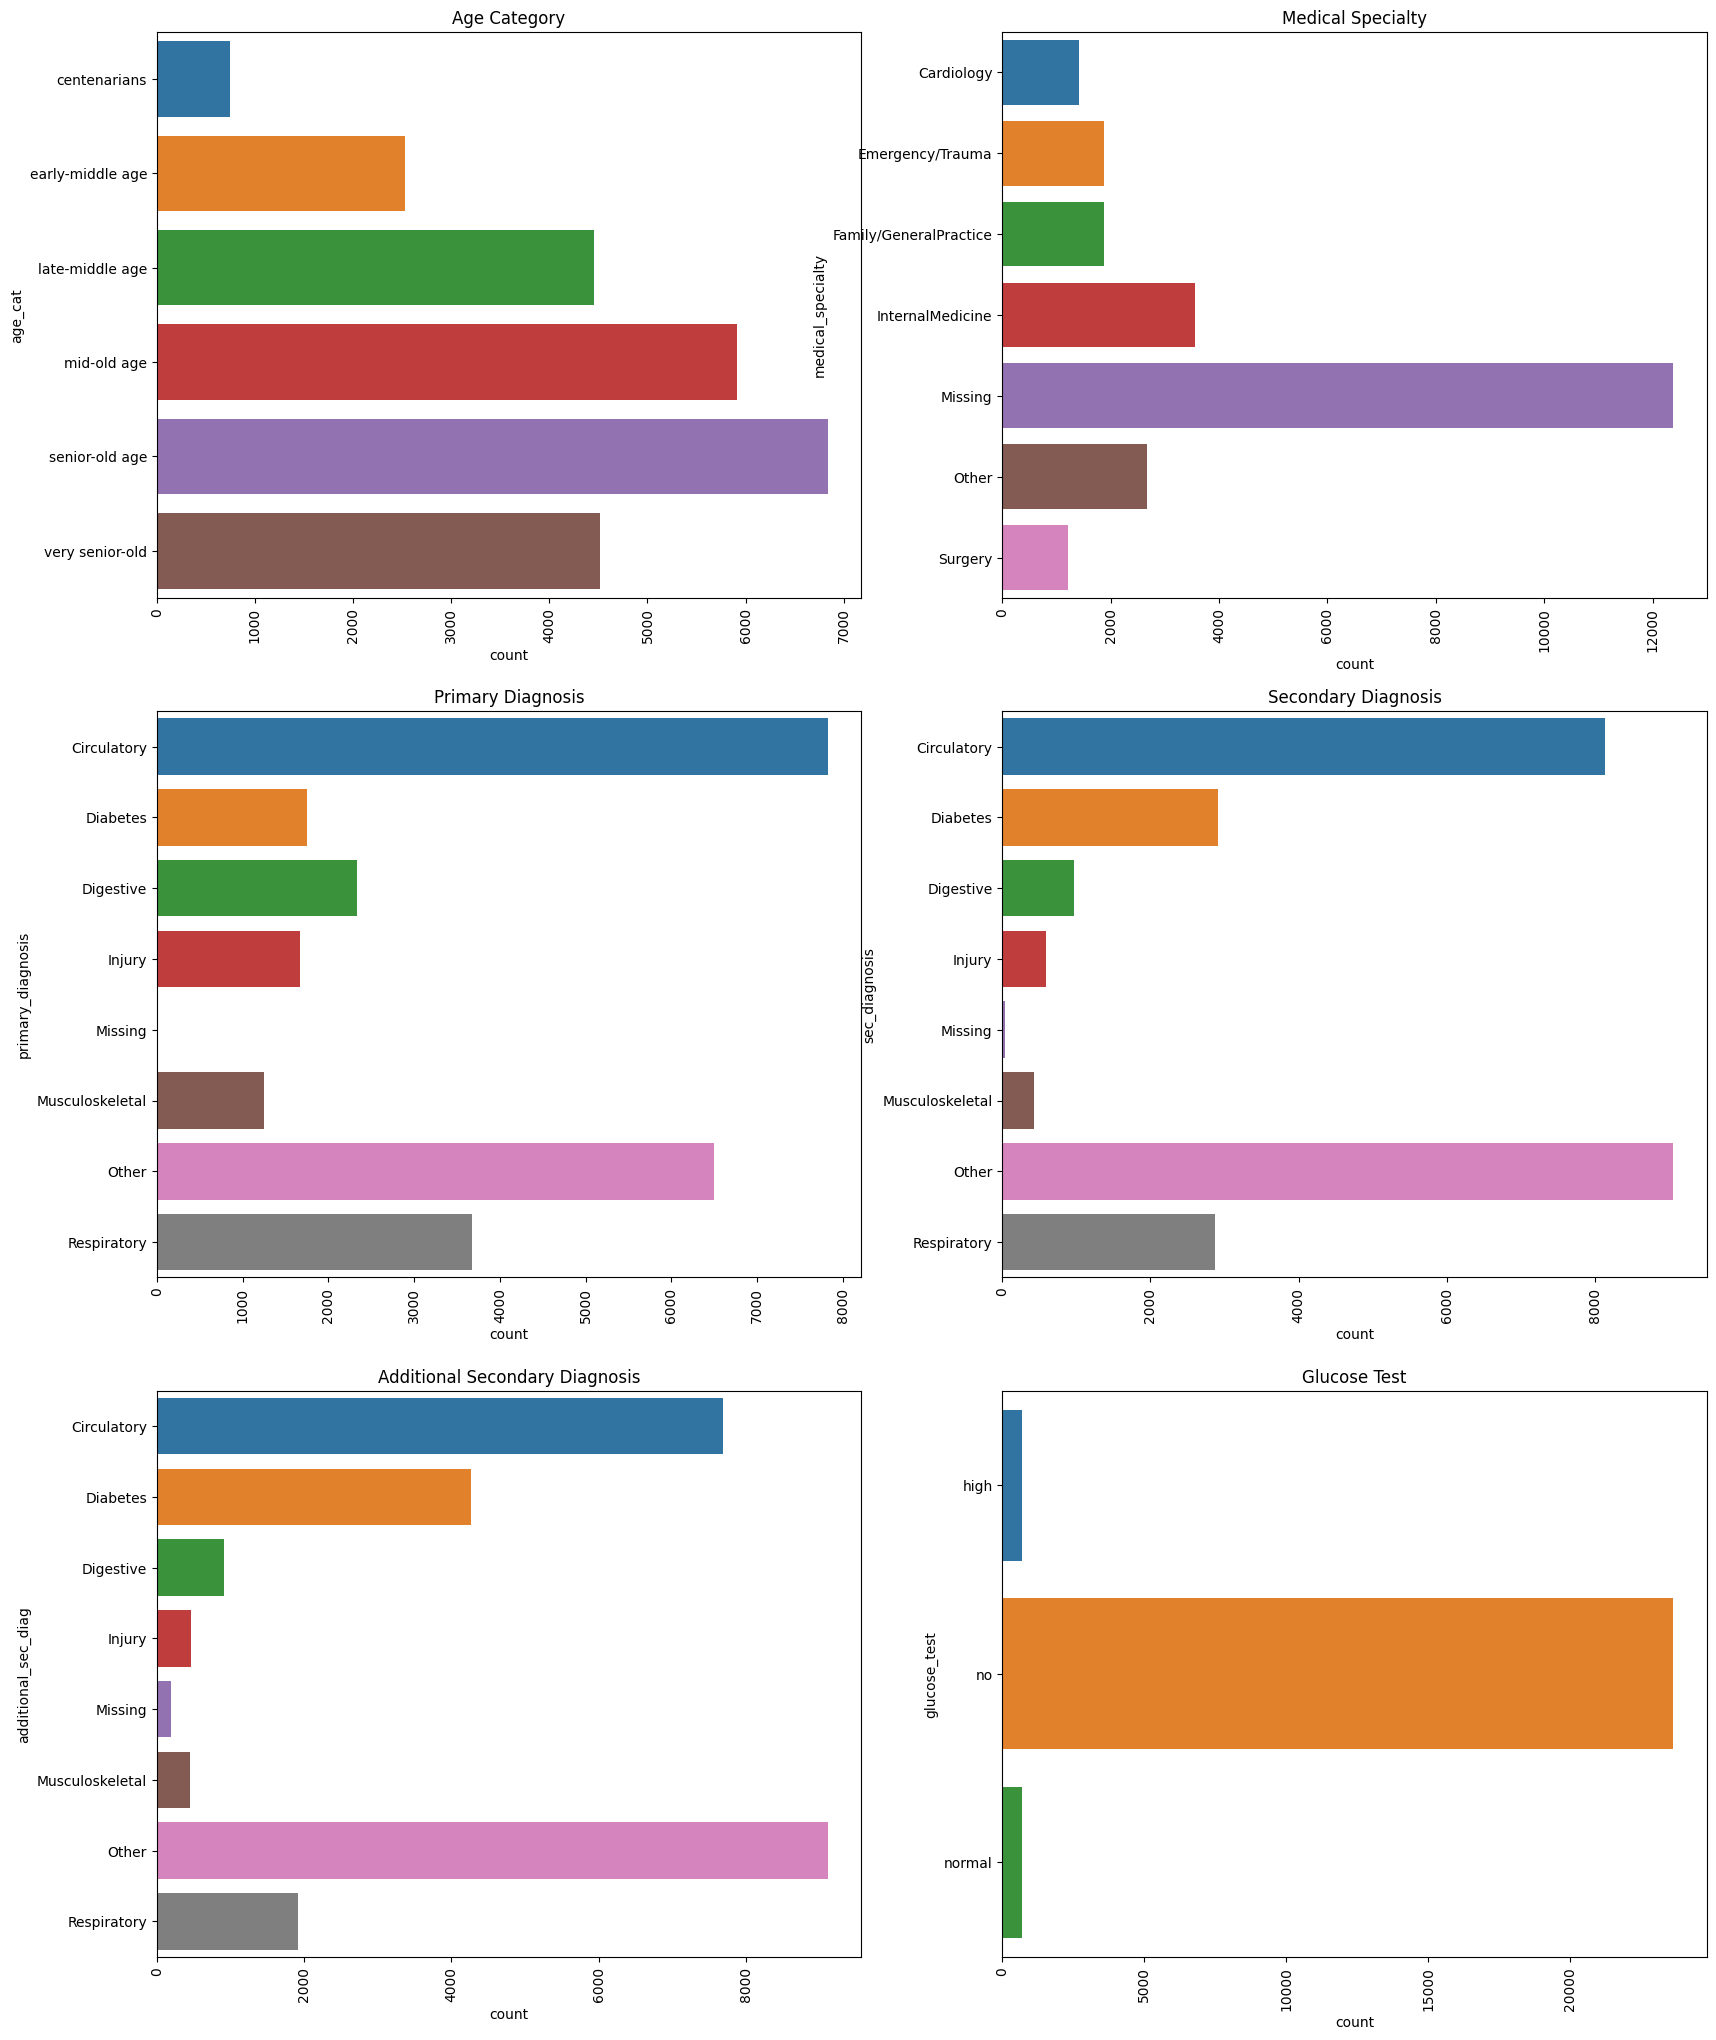

In [95]:
#visualize the information above for easy understanding
#value counting the categorical columns
plt.figure(figsize = (20, 25))
plt.subplot(3, 2, 1)
sns.countplot(y='age_cat', hue='age_cat', data=df)
plt.title('Age Category')
plt.xticks(rotation=90)


plt.subplot(3, 2, 2)
sns.countplot(y='medical_specialty', hue='medical_specialty', data=df)
plt.title('Medical Specialty')
plt.xticks(rotation=90)


plt.subplot(3, 2, 3)
sns.countplot(y='primary_diagnosis', hue='primary_diagnosis', data=df)
plt.title('Primary Diagnosis')
plt.xticks(rotation=90)


plt.subplot(3, 2, 4)
sns.countplot(y='sec_diagnosis', hue='sec_diagnosis', data=df)
plt.title('Secondary Diagnosis')
plt.xticks(rotation=90)


plt.subplot(3, 2, 5)
sns.countplot(y='additional_sec_diag', hue='additional_sec_diag', data=df)
plt.title('Additional Secondary Diagnosis')
plt.xticks(rotation=90)


plt.subplot(3, 2, 6)
sns.countplot(y='glucose_test', hue='glucose_test', data=df)
plt.title('Glucose Test')
plt.xticks(rotation=90)
plt.show()

### MOST COMMON PRIMARY DIAGNOSIS BY AGE GROUP

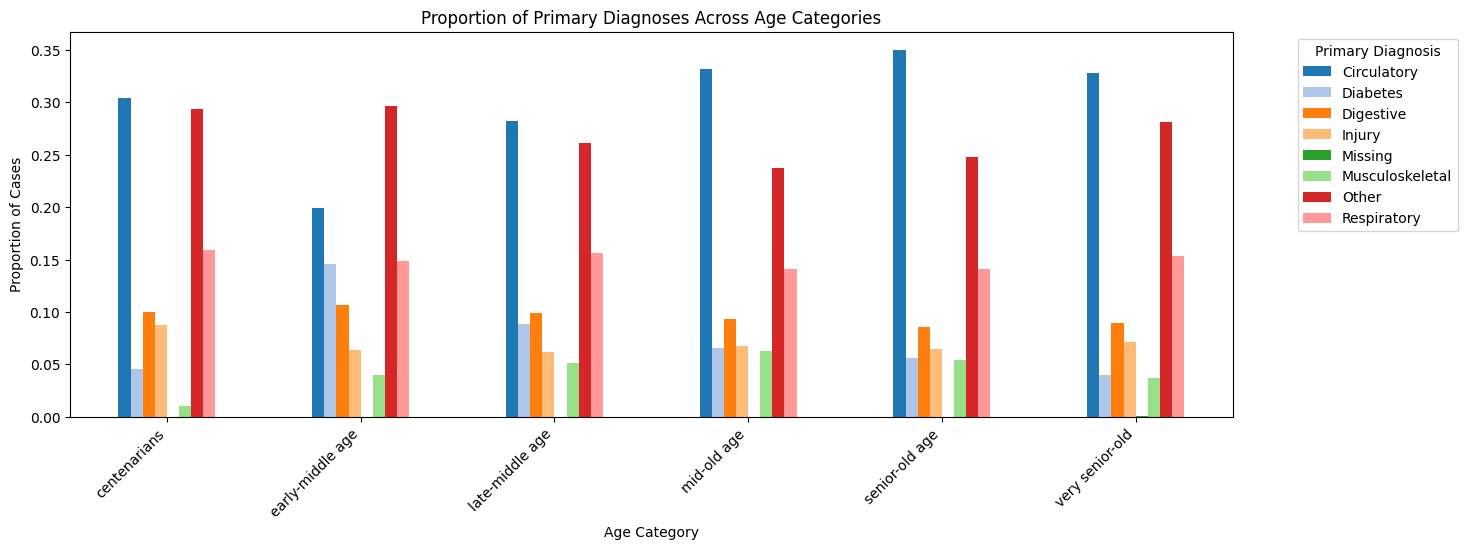

In [96]:
#using groupby and value_counts to gain insights
# Groupby and value_counts
plot_data = df.groupby('age_cat')['primary_diagnosis'].value_counts(normalize=True, sort=False).to_frame().unstack()
plot_data.columns = plot_data.columns.droplevel(0)  # Clean up MultiIndex
ax = plot_data.plot(kind='bar', stacked=False, figsize=(15, 5), color=plt.cm.tab20.colors)

# Legend
ax.legend(title='Primary Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')

# Title and labels
plt.title('Proportion of Primary Diagnoses Across Age Categories')
plt.xlabel('Age Category')
plt.ylabel('Proportion of Cases')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.show()


From the table and graph above we can see that Circulatory diagnosis was the most common primary diagnosis across the varoius categories of age outside early middle age where Others as a diagnosis cateory came first and circulatory diagnosis second.

### Diagnosises

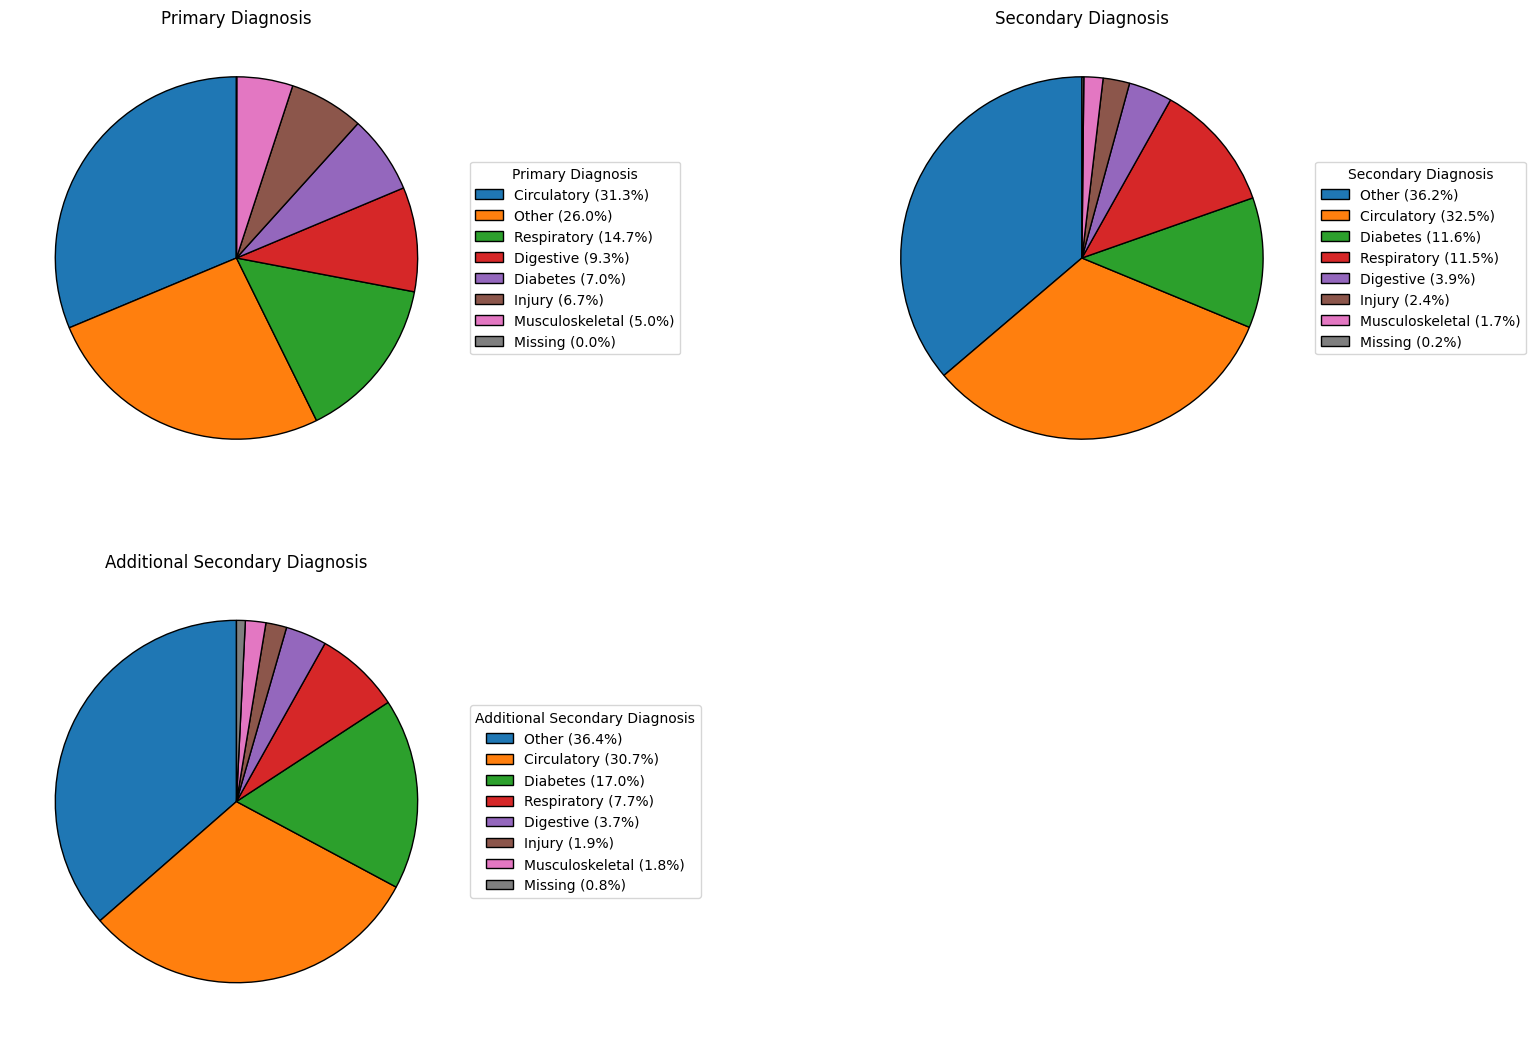

In [97]:
# Groupby and value_counts
# Adjust figure size for better spacing and layout
plt.figure(figsize=(20, 20))

primary_labels = df['primary_diagnosis'].value_counts().index
primary_sizes = df['primary_diagnosis'].value_counts().values
primary_colors = plt.cm.Paired.colors[:len(primary_labels)]
secondary_labels = df['sec_diagnosis'].value_counts().index
secondary_sizes = df['sec_diagnosis'].value_counts().values
secondary_colors = plt.cm.Paired.colors[:len(secondary_labels)]
additional_labels = df['additional_sec_diag'].value_counts().index
additional_sizes = df['additional_sec_diag'].value_counts().values
additional_colors = plt.cm.Paired.colors[:len(additional_labels)]
primary_legend_labels = [f'{label} ({size/sum(primary_sizes)*100:.1f}%)' for label, size in zip(primary_labels, primary_sizes)]
secondary_legend_labels = [f'{label} ({size/sum(secondary_sizes)*100:.1f}%)' for label, size in zip(secondary_labels, secondary_sizes)]
additional_legend_labels = [f'{label} ({size/sum(additional_sizes)*100:.1f}%)' for label, size in zip(additional_labels, additional_sizes)]

# Primary Diagnosis Pie Chart
plt.subplot(3, 2, 1)
df['primary_diagnosis'].value_counts().plot.pie(startangle=90, labels=None, wedgeprops={'edgecolor': 'black'})
plt.title('Primary Diagnosis')
plt.legend(primary_legend_labels, title="Primary Diagnosis", loc="center left", bbox_to_anchor=(1, 0.5), fontsize='medium')
plt.ylabel('')  # Remove y-axis label for clarity

# Secondary Diagnosis Pie Chart
plt.subplot(3, 2, 2)
df['sec_diagnosis'].value_counts().plot.pie(startangle=90, labels=None, wedgeprops={'edgecolor': 'black'})
plt.title('Secondary Diagnosis')
plt.legend(secondary_legend_labels, title="Secondary Diagnosis", loc="center left", bbox_to_anchor=(1, 0.5), fontsize='medium')
plt.ylabel('')

# Additional Secondary Diagnosis Pie Chart
plt.subplot(3, 2, 3)
df['additional_sec_diag'].value_counts().plot.pie(startangle=90,labels=None, wedgeprops={'edgecolor': 'black'})
plt.title('Additional Secondary Diagnosis')
plt.legend(additional_legend_labels, title="Additional Secondary Diagnosis", loc="center left", bbox_to_anchor=(1, 0.5), fontsize='medium')
plt.ylabel('')


# Show the plot
plt.show()


### Explore the effect of a diabetes diagnosis on readmission rates.

In [98]:
#subsetting patient with non-DM diagnosis
non_diabetes_pt = df[~((df['primary_diagnosis'] == 'Diabetes') | (df['sec_diagnosis'] == 'Diabetes') |
    (df['additional_sec_diag'] == 'Diabetes'))]

#subsetting patient with DM diagnosis
diabetes_pt = df[(df['primary_diagnosis'] == 'Diabetes') | (df['sec_diagnosis'] == 'Diabetes') |
    (df['additional_sec_diag'] == 'Diabetes')]

#numbers of non-DM patient
print('number of non-DM patient: ',len(non_diabetes_pt.index))

#numbers of DM patient
print('number of DM patient: ',len(diabetes_pt.index))

number of non-DM patient:  16212
number of DM patient:  8788


readmitted
no     4699
yes    4089
Name: count, dtype: int64


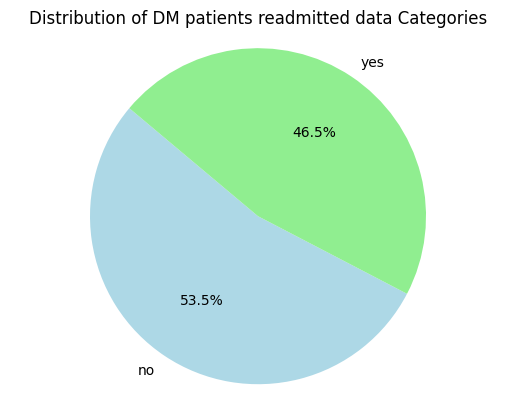

In [99]:
#plotting the distribution of DM patient readmitted data
readmitted_data = diabetes_pt['readmitted'].value_counts(normalize=False).to_dict()

# Create a figure and axis
fig, ax = plt.subplots()

# Data for the pie chart
labels = [f"{status}" for status in readmitted_data.keys()]
sizes = list(readmitted_data.values())

# Colors for the pie chart
colors = ['lightblue', 'lightgreen']

# Plot the pie chart
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Aspect ratio to make the pie circular
ax.axis('equal')

# Title for the pie chart
plt.title('Distribution of DM patients readmitted data Categories')

print(diabetes_pt['readmitted'].value_counts(normalize=False))
# Show the pie chart
plt.show()

readmitted
no     8547
yes    7665
Name: count, dtype: int64


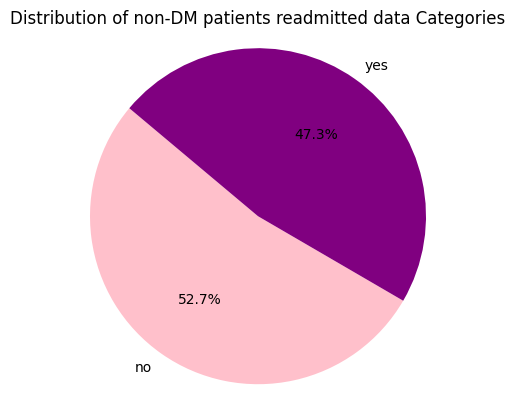

In [100]:
# plot the distribution of non-DM patient readmitted data
readmitted_data = non_diabetes_pt['readmitted'].value_counts(normalize=False).to_dict()

# Create a figure and axis
fig, ax = plt.subplots()

# Data for the pie chart
labels = [f"{status}" for status in readmitted_data.keys()]
sizes = list(readmitted_data.values())

# Colors for the pie chart
colors = ['pink', 'purple']

# Plot the pie chart
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Aspect ratio to make the pie circular
ax.axis('equal')

# Title for the pie chart
plt.title('Distribution of non-DM patients readmitted data Categories')

print(non_diabetes_pt['readmitted'].value_counts(normalize=False))
# Show the pie chart
plt.show()


In [101]:
#table showing the count of readmitted patient for each diagnosis
# pd.set_option('display.max_rows', 64)
df.groupby(['primary_diagnosis','sec_diagnosis','additional_sec_diag'])['readmitted'].count().to_frame().unstack()
# rp.columns = rp.columns.droplevel(0)  # Clean up MultiIndex
# rp.fillna(0, inplace=True)
# rp = rp.astype(int)
# rp

readmitted                            \
additional_sec_diag               Circulatory Diabetes Digestive Injury   
primary_diagnosis sec_diagnosis                                           
Circulatory       Circulatory            1724      877        48     66   
                  Diabetes                394       28        12      8   
                  Digestive                26        6        10      0   
                  Injury                   70       21         3     14   
                  Missing                   3        0         0      0   
...                                       ...      ...       ...    ...   
Respiratory       Injury                    7        2         0      2   
                  Missing                   0        1         0      0   
                  Musculoskeletal           8       11         1      0   
                  Other                   247      196        17     14   
                  Respiratory             293      180        16     11   

                                                                             
additional_sec_diag               Missing Musculoskeletal Other Respiratory  
primary_diagnosis sec_diagnosis                                              
Circulatory       Circulatory           2              25   958         366  
                  Diabetes             20              11   331          35  
                  Digestive             0               1    31           4  
                  Injury                0               0    40           6  
                  Missing               0               0     2           0  
...                                   ...             ...   ...         ...  
Respiratory       Injury                0               0     8           4  
                  Missing               0               0     0           0  
                  Musculoskeletal       0               5    13           8  
                  Other                 1              15   358         108  
                  Respiratory           0              10   254         137  

[64 rows x 8 columns]

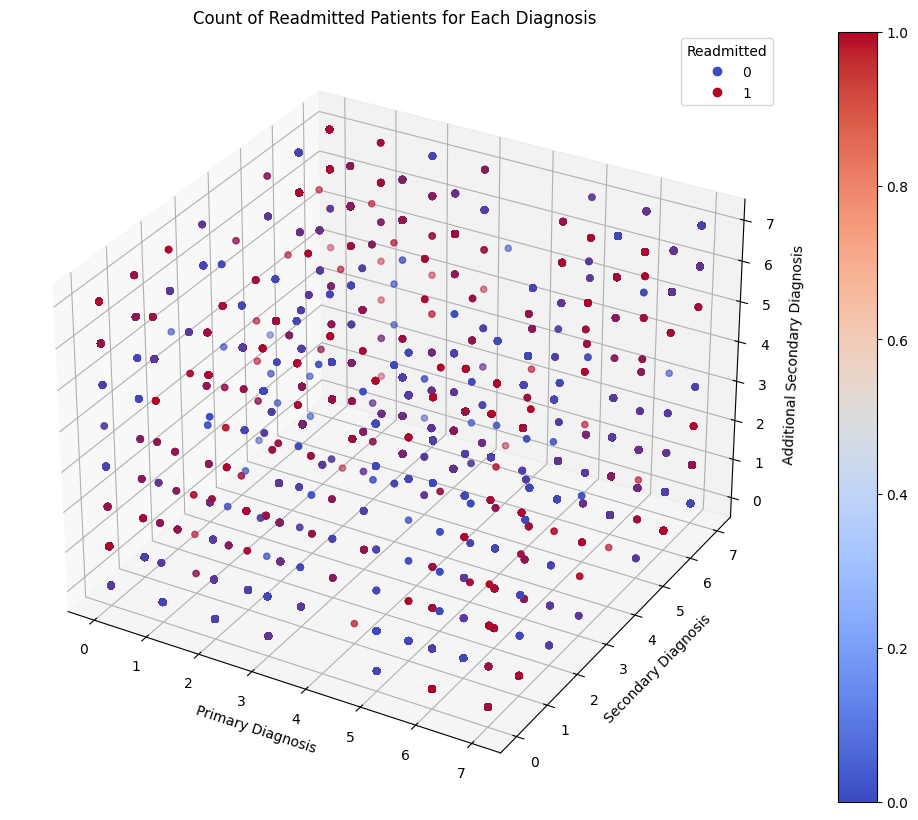

In [102]:
# Map 'yes' to 1 and 'no' to 0 in the 'readmitted' column
es = df['readmitted'].map({'yes': 1, 'no': 0})

# Convert categorical data to numeric codes
x = df['primary_diagnosis'].cat.codes
y = df['sec_diagnosis'].cat.codes
z = df['additional_sec_diag'].cat.codes

# Set color based on 'readmitted' column
c = es

# Adjust the figure size for better viewing
fig = plt.figure(figsize=(15, 10))

# Create a 3D plot
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D heatmap
img = ax.scatter(x, y, z, c=c, cmap='coolwarm', marker='o')

# Add a color bar
fig.colorbar(img)

# Set axis labels
ax.set_xlabel('Primary Diagnosis')
ax.set_ylabel('Secondary Diagnosis')
ax.set_zlabel('Additional Secondary Diagnosis')

# Set title
plt.title('Count of Readmitted Patients for Each Diagnosis')

# Position legend outside the plot
plt.legend(*img.legend_elements(), title='Readmitted')

# Show the 3D heatmap
plt.show()


After exploring the data I could deduct that about 8788 patients had Diabetes as either a primary diagnosis, secondary diagnosis or additional secondary diagnosis. This made up about one-third of the patients population.Amongst the DM patient approximately 47 percent were readmitted while 53 percent where not. While about 16212 patients did not have DM as either a primary diagnosis, secondary diagnosis or additional secondary diagnosis.This makes about two-third of the patients population.Amongst the non-DM patients approximately 47 percent were readmitted while 53 percent were not. From the analysis we cannot really say if diabetes plays a central role in readmission as they could be other factors causing patients readmission but we can deduct that majority of the patients had diabetes as a diagnosis logically making them occupy a high readmission rates

### what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?

In [103]:
#viewing the dataset
df.head()

time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0                 8                72             1             18   
1                 3                34             2             13   
2                 5                45             0             18   
3                 2                36             0             12   
4                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty primary_diagnosis  \
0             2            0            0           Missing       Circulatory   
1             0            0            0             Other             Other   
2             0            0            0           Missing       Circulatory   
3             1            0            0           Missing       Circulatory   
4             0            0            0  InternalMedicine             Other   

  sec_diagnosis additional_sec_diag glucose_test HbA1ctest med_change  \
0   Respiratory               Other           no        no         no   
1         Other               Other           no        no         no   
2   Circulatory         Circulatory           no        no        yes   
3         Other            Diabetes           no        no        yes   
4   Circulatory         Respiratory           no        no         no   

  diabetes_med readmitted          age_cat  
0          yes         no   senior-old age  
1          yes         no   senior-old age  
2          yes        yes  late-middle age  
3          yes        yes   senior-old age  
4          yes         no      mid-old age

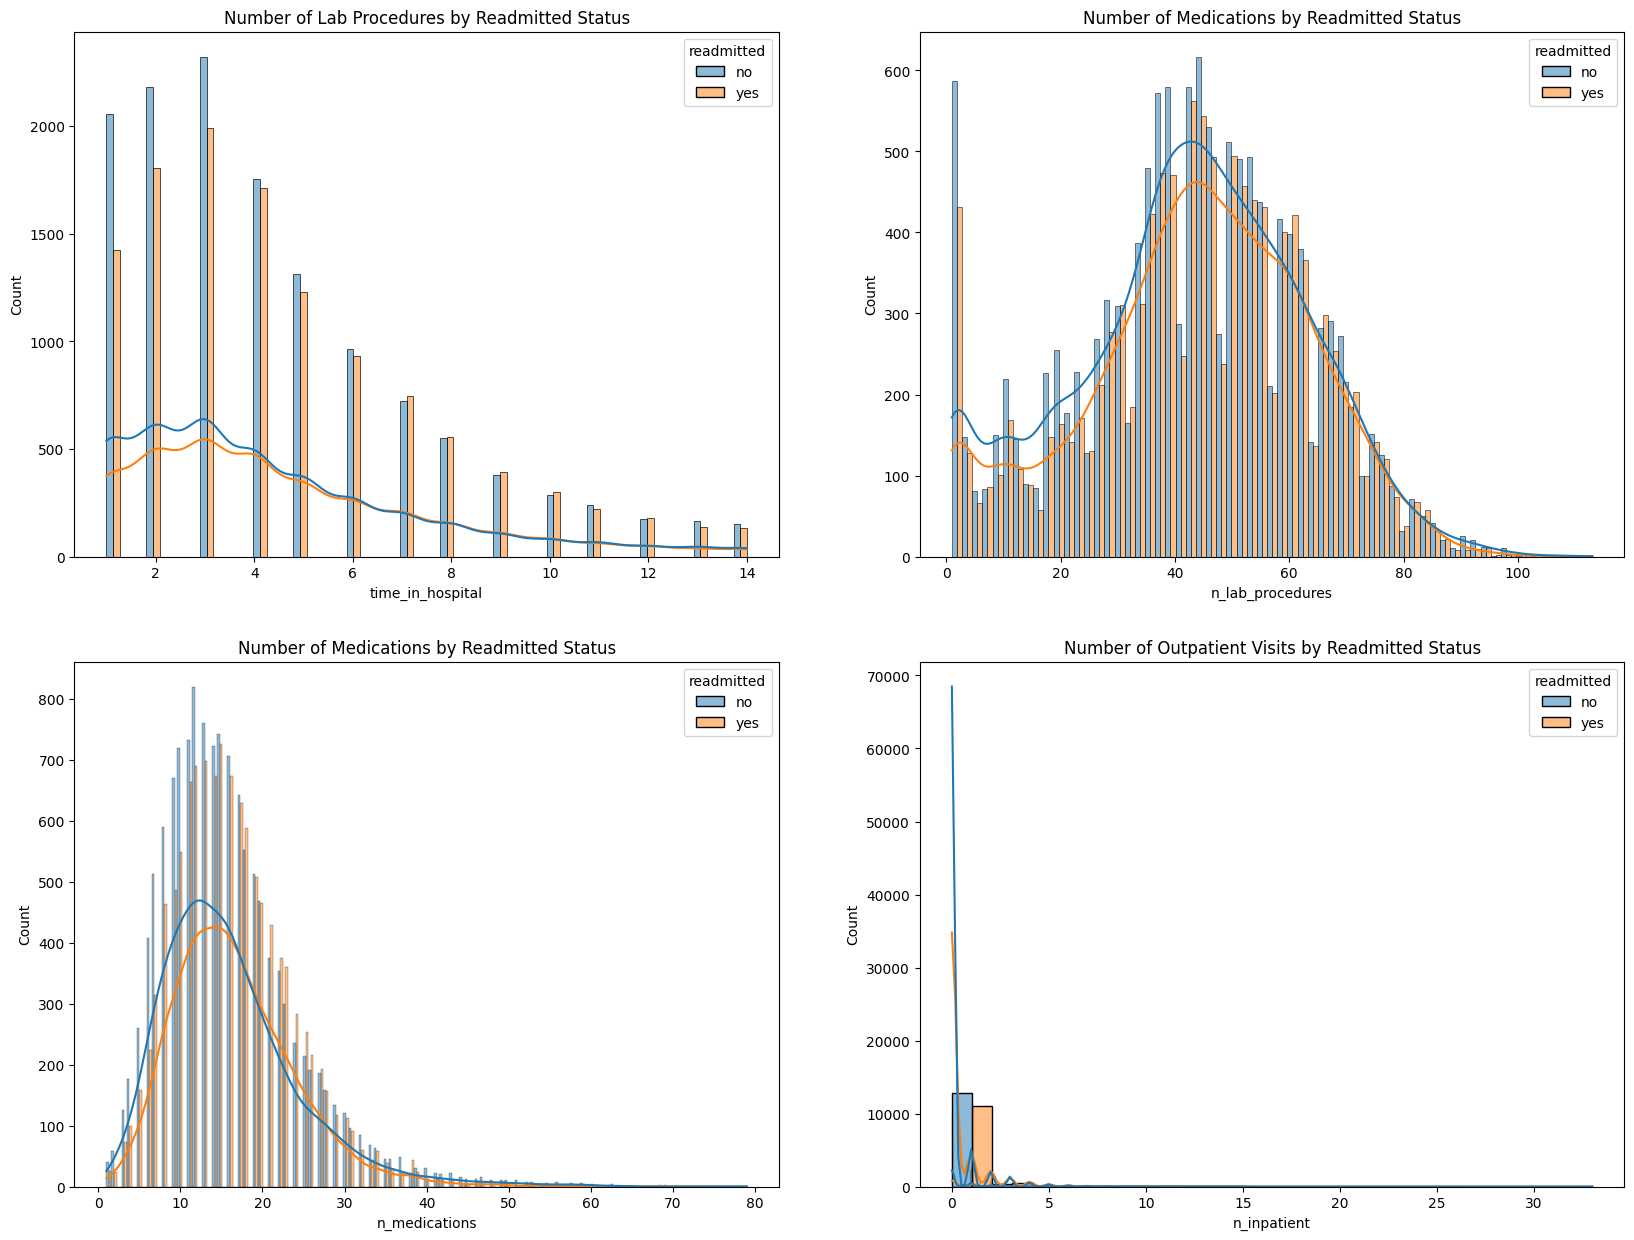

In [104]:
#plotting a grap showing the distribution of numerical columns by their readmitted status
# Create a figure and axis
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# Plot the distribution of 'time_in_hospital' by 'readmitted' status
sns.histplot(df, x='time_in_hospital', hue='readmitted', multiple='dodge',kde=True, ax=ax[0, 0])
ax[0, 0].set_title('Number of Lab Procedures by Readmitted Status')

# Plot the distribution of 'n_lab_procedures' by 'readmitted' status
sns.histplot(df, x='n_lab_procedures', hue='readmitted', multiple='dodge',kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Number of Medications by Readmitted Status')

# Plot the distribution of 'n_medications' by 'readmitted' status
sns.histplot(df, x='n_medications', hue='readmitted', multiple='dodge',kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Number of Medications by Readmitted Status')

# Plot the distribution of 'n_inpatient' by 'readmitted' status
sns.histplot(df, x='n_inpatient', hue='readmitted', multiple='dodge',kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Number of Inpatient Visits by Readmitted Status')

# plot the distribution of 'n_outpatient' by 'readmitted' status
sns.histplot(df, x='n_outpatient', hue='readmitted', multiple='dodge',kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Number of Outpatient Visits by Readmitted Status')

# Show the plots
plt.show()

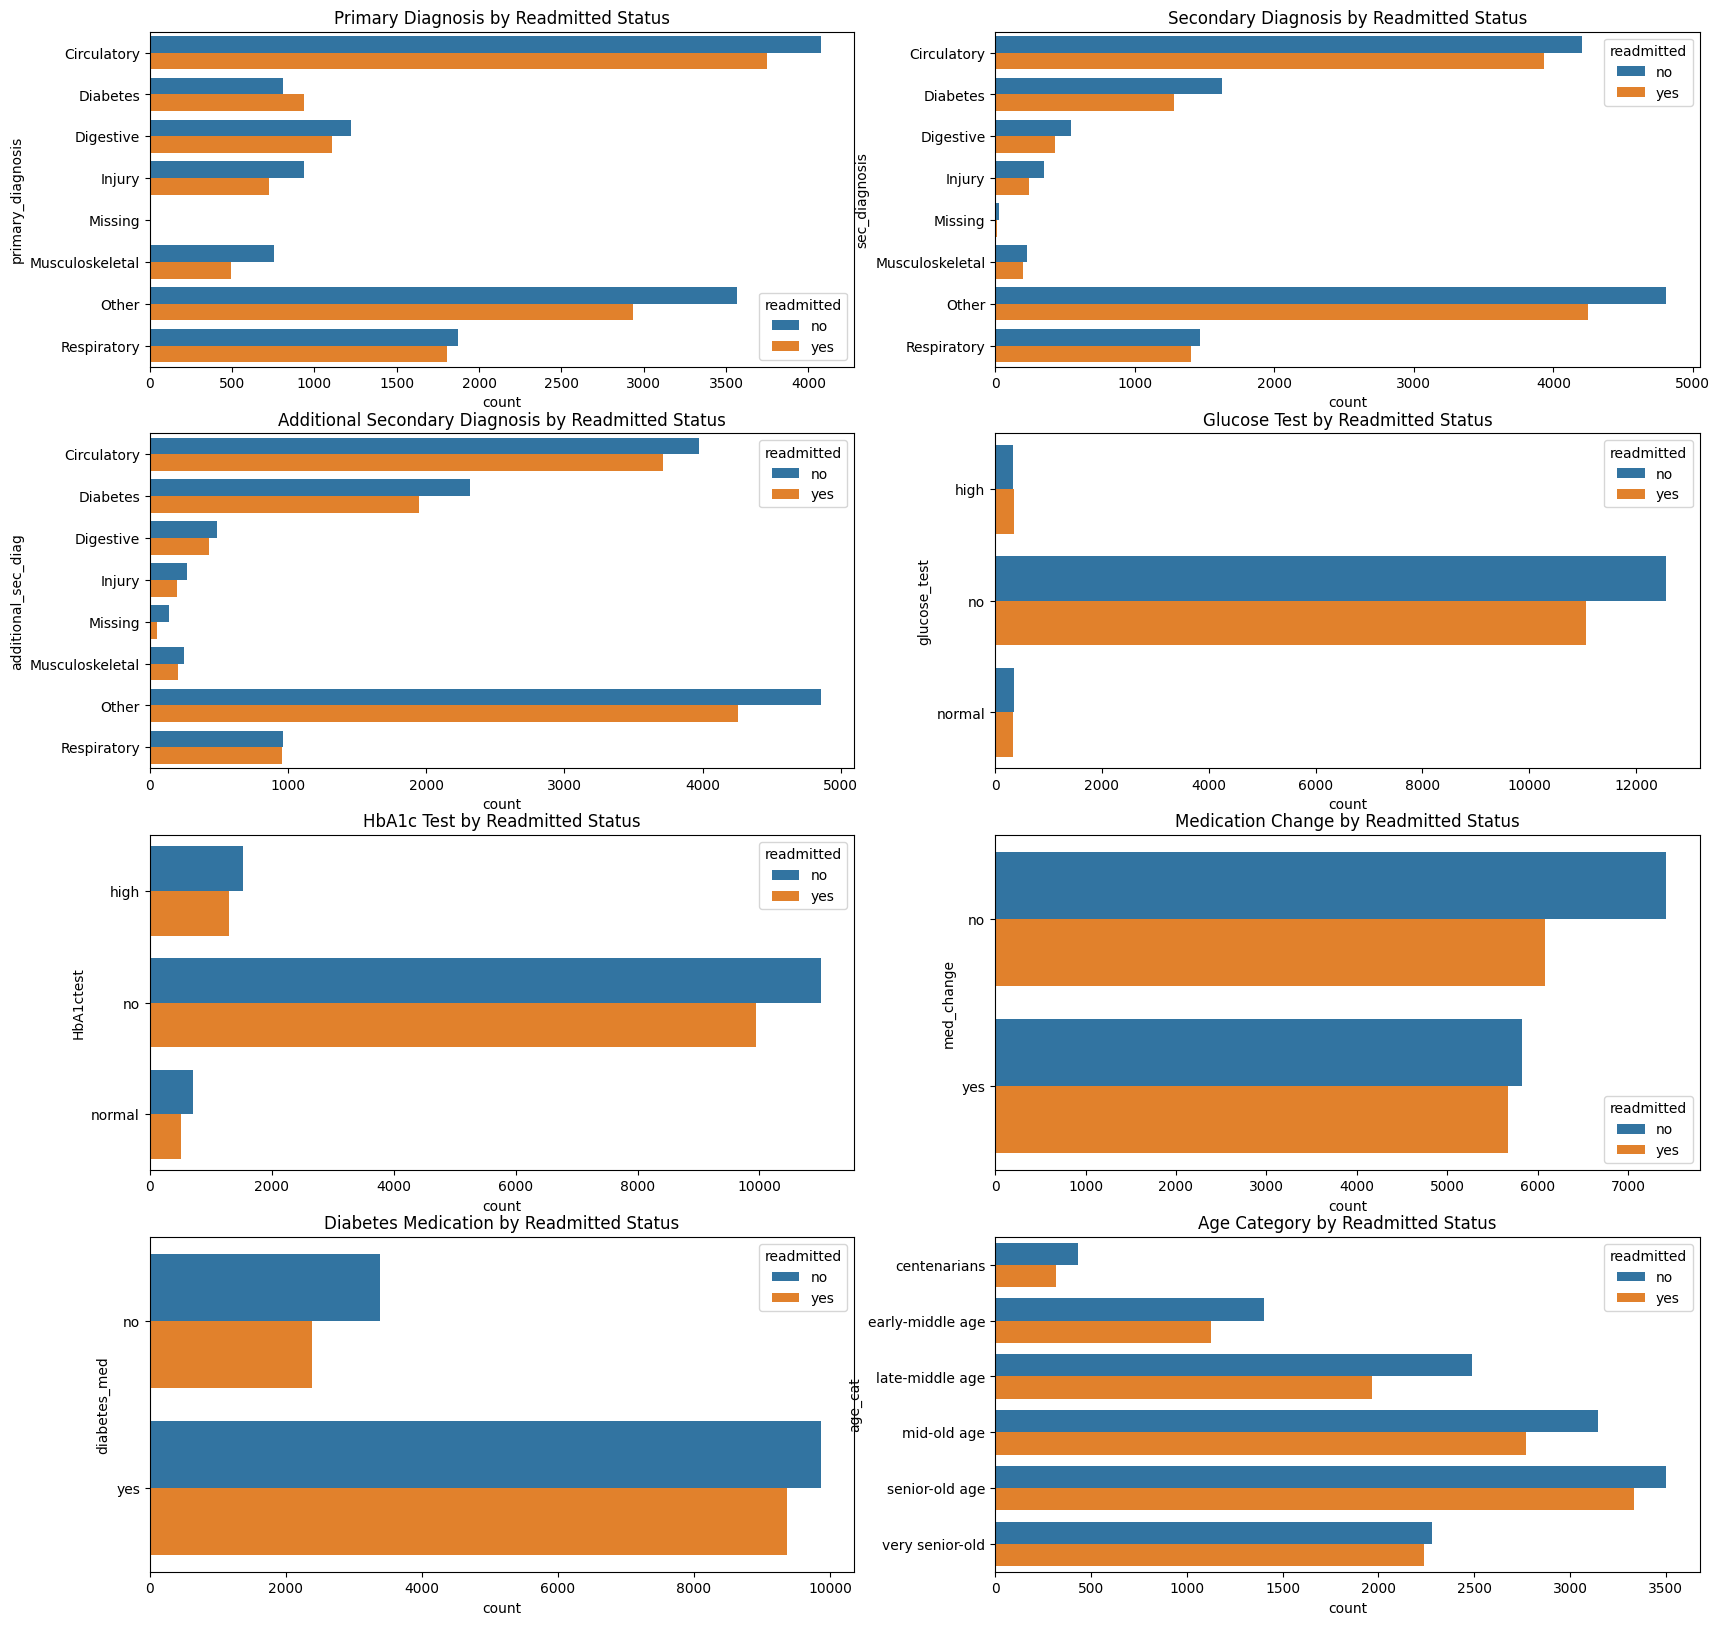

In [105]:
#visualizing the categorical columns by thier readmitted status

# Create a figure and axis
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# Plot the distribution of 'primary_diagnosis' by 'readmitted' status
sns.countplot(y='primary_diagnosis', hue='readmitted', data=df, ax=ax[0, 0])
ax[0, 0].set_title('Primary Diagnosis by Readmitted Status')

# Plot the distribution of 'sec_diagnosis' by 'readmitted' status
sns.countplot(y='sec_diagnosis', hue='readmitted', data=df, ax=ax[0, 1])
ax[0, 1].set_title('Secondary Diagnosis by Readmitted Status')

# Plot the distribution of 'additional_sec_diag' by 'readmitted' status
sns.countplot(y='additional_sec_diag', hue='readmitted', data=df, ax=ax[1, 0])
ax[1, 0].set_title('Additional Secondary Diagnosis by Readmitted Status')

# Plot the distribution of 'glucose_test' by 'readmitted' status
sns.countplot(y='glucose_test', hue='readmitted', data=df, ax=ax[1, 1])
ax[1, 1].set_title('Glucose Test by Readmitted Status')

# Plot the distribution of 'HbA1ctest' by 'readmitted' status
sns.countplot(y='HbA1ctest', hue='readmitted', data=df, ax=ax[2, 0])
ax[2, 0].set_title('HbA1c Test by Readmitted Status')

# Plot the distribution of 'med_change' by 'readmitted' status
sns.countplot(y='med_change', hue='readmitted', data=df, ax=ax[2, 1])
ax[2, 1].set_title('Medication Change by Readmitted Status')

# Plot the distribution of 'diabetes_med' by 'readmitted' status
sns.countplot(y='diabetes_med', hue='readmitted', data=df, ax=ax[3, 0])
ax[3, 0].set_title('Diabetes Medication by Readmitted Status')

# Plot the distribution of 'age_cat' by 'readmitted' status
sns.countplot(y='age_cat', hue='readmitted', data=df, ax=ax[3, 1])
ax[3, 1].set_title('Age Category by Readmitted Status')

# Show the plots
plt.show()

In [106]:
# convert categorical columns to numerical columns using label encoding
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Apply the LabelEncoder to the categorical columns
df['medical_specialty'] = le.fit_transform(df['medical_specialty'])
df['primary_diagnosis'] = le.fit_transform(df['primary_diagnosis'])
df['sec_diagnosis'] = le.fit_transform(df['sec_diagnosis'])
df['additional_sec_diag'] = le.fit_transform(df['additional_sec_diag'])
df['age_cat'] = le.fit_transform(df['age_cat'])
df['glucose_test'] = le.fit_transform(df['glucose_test'])
df['HbA1ctest'] = le.fit_transform(df['HbA1ctest'])
df['med_change'] = le.fit_transform(df['med_change'])
df['diabetes_med'] = le.fit_transform(df['diabetes_med'])
df['readmitted'] = le.fit_transform(df['readmitted'])


#viewing the dataset
df.head()

time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0                 8                72             1             18   
1                 3                34             2             13   
2                 5                45             0             18   
3                 2                36             0             12   
4                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency  medical_specialty  \
0             2            0            0                  4   
1             0            0            0                  5   
2             0            0            0                  4   
3             1            0            0                  4   
4             0            0            0                  3   

   primary_diagnosis  sec_diagnosis  additional_sec_diag  glucose_test  \
0                  0              7                    6             1   
1                  6              6                    6             1   
2                  0              0                    0             1   
3                  0              6                    1             1   
4                  6              0                    7             1   

   HbA1ctest  med_change  diabetes_med  readmitted  age_cat  
0          1           0             1           0        4  
1          1           0             1           0        4  
2          1           1             1           1        2  
3          1           1             1           1        4  
4          1           0             1           0        3

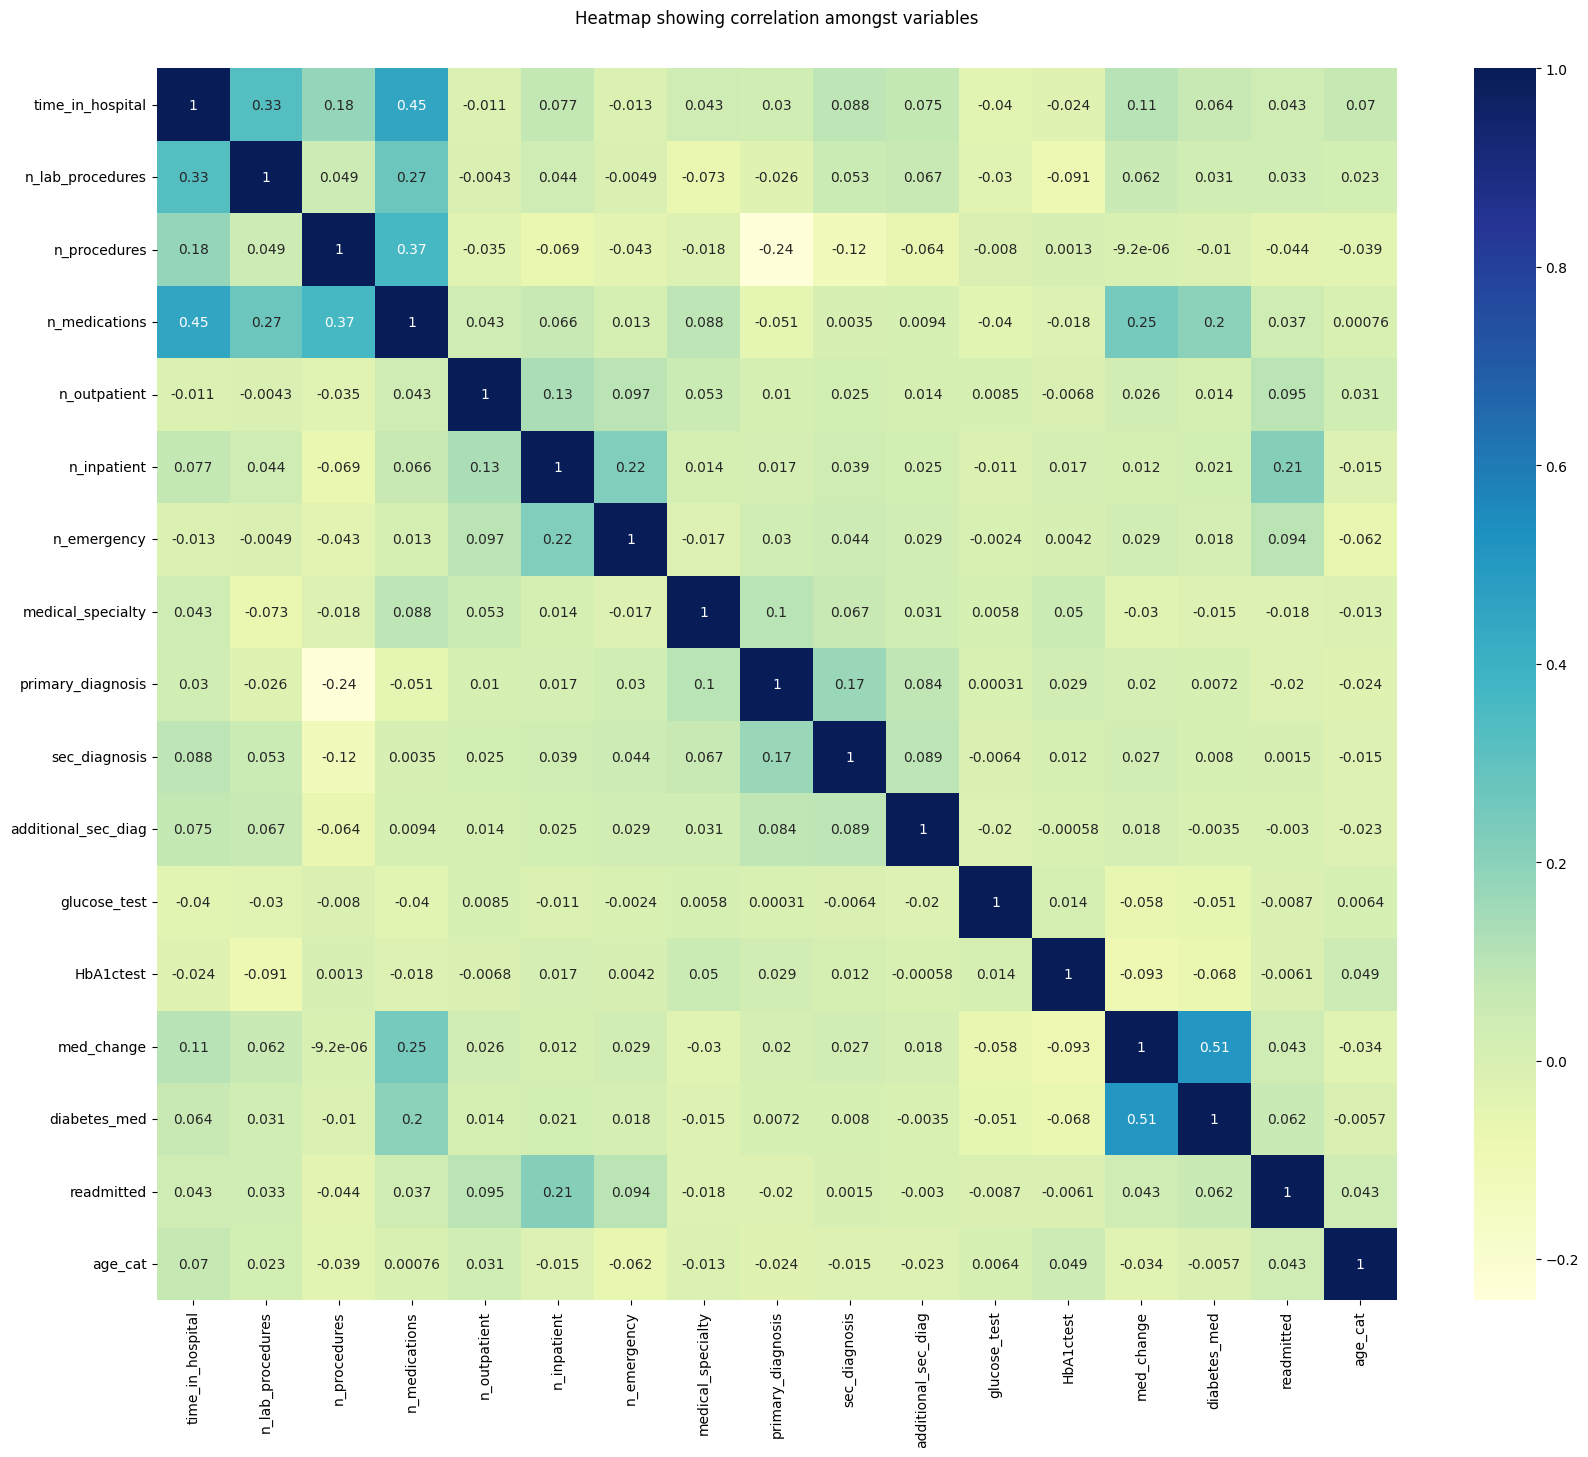

In [107]:
#show correlation of numerical columns
df_numeric = df.select_dtypes(include=['number'])

# Calculate correlation matrix between selected columns
correlation_matrix = df_numeric.corr()

#visualizing correlation between variables
plt.figure(figsize=(20,16))
sns.heatmap(correlation_matrix, cmap='YlGnBu', fmt='.2g', annot=True)

plt.title('Heatmap showing correlation amongst variables',y=1.03)
plt.show()

In [108]:
# Select columns for clustering
quantCols = df.select_dtypes(include=[int,float]).columns

# Create new DataFrame with clustering variables
df_features = df[quantCols]

df_features

time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0                     8                72             1             18   
1                     3                34             2             13   
2                     5                45             0             18   
3                     2                36             0             12   
4                     1                42             0              7   
...                 ...               ...           ...            ...   
24995                14                77             1             30   
24996                 2                66             0             24   
24997                 5                12             0              6   
24998                 2                61             3             15   
24999                10                37             1             24   

       n_outpatient  n_inpatient  n_emergency  medical_specialty  \
0                 2            0            0                  4   
1                 0            0            0                  5   
2                 0            0            0                  4   
3                 1            0            0                  4   
4                 0            0            0                  3   
...             ...          ...          ...                ...   
24995             0            0            0                  4   
24996             0            0            0                  4   
24997             0            1            0                  4   
24998             0            0            0                  2   
24999             0            0            0                  4   

       primary_diagnosis  sec_diagnosis  additional_sec_diag  glucose_test  \
0                      0              7                    6             1   
1                      6              6                    6             1   
2                      0              0                    0             1   
3                      0              6                    1             1   
4                      6              0                    7             1   
...                  ...            ...                  ...           ...   
24995                  0              6                    0             1   
24996                  2              3                    6             1   
24997                  6              6                    6             2   
24998                  7              1                    6             1   
24999                  6              1                    0             1   

       HbA1ctest  med_change  diabetes_med  readmitted  age_cat  
0              1           0             1           0        4  
1              1           0             1           0        4  
2              1           1             1           1        2  
3              1           1             1           1        4  
4              1           0             1           0        3  
...          ...         ...           ...         ...      ...  
24995          2           0             0           1        5  
24996          0           1             1           1        5  
24997          1           0             0           1        4  
24998          1           1             1           0        4  
24999          1           0             0           1        2  

[25000 rows x 17 columns]

In [109]:
#Transforming all colimns that have noticeable skewness
transformCols = ['time_in_hospital','n_lab_procedures','n_procedures',
                 'n_medications','n_outpatient','n_inpatient','n_emergency']
all([pd.api.types.is_numeric_dtype(df_features[col]) for col in transformCols])

True

In [110]:
df_log = df_features.copy()
# Perform a log transformation of the data to unskew the data
for feat in transformCols:
    #Add one to avoid INF values
    df_log[feat] = np.log(1+df_features[feat])

#Check how many INF readings we have in the data
np.isinf(df_log).sum()


time_in_hospital       0
n_lab_procedures       0
n_procedures           0
n_medications          0
n_outpatient           0
n_inpatient            0
n_emergency            0
medical_specialty      0
primary_diagnosis      0
sec_diagnosis          0
additional_sec_diag    0
glucose_test           0
HbA1ctest              0
med_change             0
diabetes_med           0
readmitted             0
age_cat                0
dtype: int64

In [111]:
#Change INF values to mean for each feature
for i in transformCols:
    df_log[i].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_log[i] = df_log[i].fillna(df_log[i].mean())

np.isinf(df_log).sum()

time_in_hospital       0
n_lab_procedures       0
n_procedures           0
n_medications          0
n_outpatient           0
n_inpatient            0
n_emergency            0
medical_specialty      0
primary_diagnosis      0
sec_diagnosis          0
additional_sec_diag    0
glucose_test           0
HbA1ctest              0
med_change             0
diabetes_med           0
readmitted             0
age_cat                0
dtype: int64

In [112]:
# import make_pipeline
from sklearn.pipeline import make_pipeline
# Instantiate StandardScaler, PCA as scaler and pca respectively
scaler = StandardScaler()
pca = PCA()
# Create the pipeline using scaler and the pca object
pipeline = make_pipeline(scaler, pca)

# Fit and transform the model
df_normalized = pipeline.fit_transform(df_log)
df_normalized.shape


(25000, 17)

Text(0.5, 1.01, 'Preprocessed Variable Distributions')

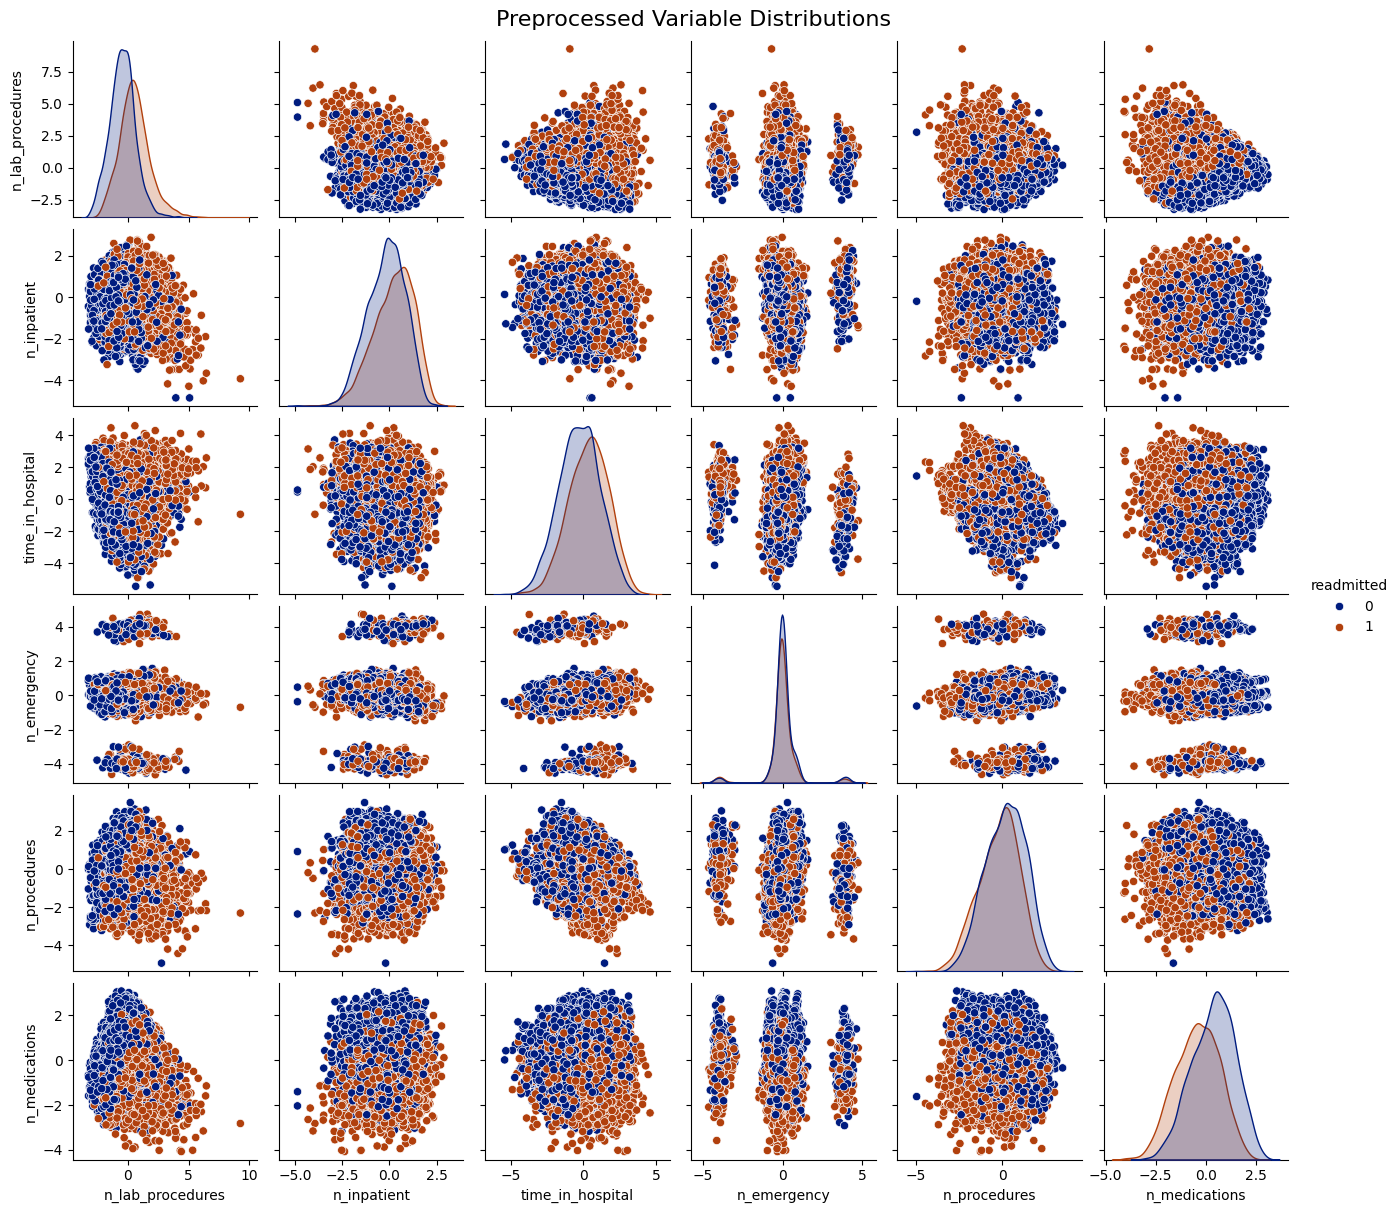

In [113]:

df_processed = pd.DataFrame(
    data=df_normalized, index=df_log.index, columns=df_log.columns
)
df_processed['readmitted'] = df_features['readmitted']
g = sns.pairplot(data=df_processed.sample(10000), 

             vars = ['n_lab_procedures', 'n_inpatient', 'time_in_hospital', 
                     'n_emergency', 'n_procedures', 'n_medications'],  
             kind="scatter", # kind of plots for each pair {‘scatter’, ‘kde’, ‘hist’, ‘reg’}
             diag_kind="kde",   # kind of plots on the diagonal {‘scatter’, ‘kde’, ‘hist’, ‘reg’}
             hue="readmitted",
             height=2,
             aspect=1.1,
             palette="dark"
             )
g.fig.suptitle("Preprocessed Variable Distributions", fontsize=16, y=1.01)


### Data Visualization summary

From the graphs above, there are no significant factor that could show what group of patient were more likely to be readmitted as their distribution and patterns were alike across all categories of readmitted status.

However, we can notice the heatmap shows a weak correlation between n_inpatient and readmitted

In [114]:
# Convert categorical columns to numerical columns
df_numeric = df.select_dtypes(include=['number'])

# Calculate the variance of numerical columns
variance = df_numeric.var()

variance


time_in_hospital        9.01
n_lab_procedures      392.78
n_procedures            2.94
n_medications          64.97
n_outpatient            1.43
n_inpatient             1.39
n_emergency             0.78
medical_specialty       2.03
primary_diagnosis       8.00
sec_diagnosis           8.49
additional_sec_diag     8.05
glucose_test            0.06
HbA1ctest               0.16
med_change              0.25
diabetes_med            0.18
readmitted              0.25
age_cat                 1.82
dtype: float64

## Data Spliting

In [115]:
# Split the data into two DataFrames: X (features) and y (target variable)
X = df_processed.drop(columns=['readmitted'],axis=1)  # Specify at least one column as a feature
y = df_processed["readmitted"]  # Specify one column as the target variable

# Split the data into train and test subsets
# You can adjust the test size and random state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.275, random_state=123
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18124, 16), (6876, 16), (18124,), (6876,))

## Tranning and Testing

In [116]:
# Dictionaries to store metrics
metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "AUC-ROC": []
}

## Run a RandomForestRegressor & Extract Feature Importances

In [117]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "n_estimators": 97,  # Number of trees in the forest
    "max_depth": 10,  # Max depth of the tree
    "min_samples_split": 3,  # Min number of samples required to split a node
    "min_samples_leaf": 1,  # Min number of samples required at a leaf node
    "ccp_alpha": 0,  # Cost complexity parameter for pruning
    "random_state": 123,
}
#{'n_estimators': 97, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 10, 'ccp_alpha': 0}

# Create a RandomForestRegressor object with the parameters above
rf = RandomForestClassifier(**params)

# Train the random forest on the train set
rf = rf.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = rf.predict(X_test)

In [118]:
y_pred = rf.predict(X_test)
print('Training Set:', rf.score(X_train,y_train))
print('Test Set:', rf.score(X_test,y_test))

# Calculate the accuracy, precision, and recall scores
print("Accuracy:", "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred)*100))
print("Area Under the Curve:", "{:.2f}%".format(roc_auc_score(y_test, y_pred)*100))



Training Set: 1.0
Test Set: 0.9968004653868529
Accuracy: 99.68%
Precision: 99.47%
Recall: 99.84%
Area Under the Curve: 99.69%


*The result is overfitted*

### Cross Validation
We have imbalanced data so we need to conduct some cross validation

In [119]:
scores = cross_val_score(rf, X_test, y_test, error_score="raise", cv=5, verbose=True)
scores

array([0.99709302, 0.99636364, 0.992     , 0.99418182, 0.99636364])

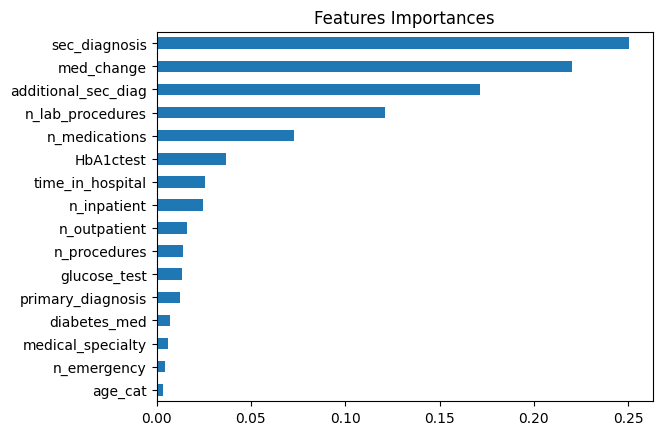

In [120]:
# Create a sorted Series of features importances
importances_sorted = pd.Series(
    data=rf.feature_importances_, index=X_train.columns
).sort_values()

# Plot a horizontal barplot of importances_sorted
importances_sorted.plot(kind="barh")
plt.title("Features Importances")
plt.show()

### Parameter Tuning

In [121]:


# Define a parameter grid with distributions of possible parameters to use
rs_param_grid = {
    "n_estimators": list((range(20, 200))),
    "max_depth": list((range(3, 15))),
    "min_samples_split": list((range(2, 5))),
    "min_samples_leaf": list((range(1, 5))),
    "ccp_alpha": [0, 0.001, 0.01, 0.1],
}

# Create a RandomForestRegressor
rf = RandomForestClassifier(random_state=123)

# Instantiate RandomizedSearchCV() with rf and the parameter grid
rf_rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rs_param_grid,
    cv=3,  # Number of folds
    n_iter=10,  # Number of parameter candidate settings to sample
    verbose=1,  # The higher this is, the more messages are outputed
    scoring="accuracy",  # Metric to evaluate performance
    random_state=123
)

# Train the model on the training set
rf_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", rf_rs.best_params_)
print("Best performance: ", rf_rs.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 121, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 13, 'ccp_alpha': 0}
Best performance:  0.9970757220196544


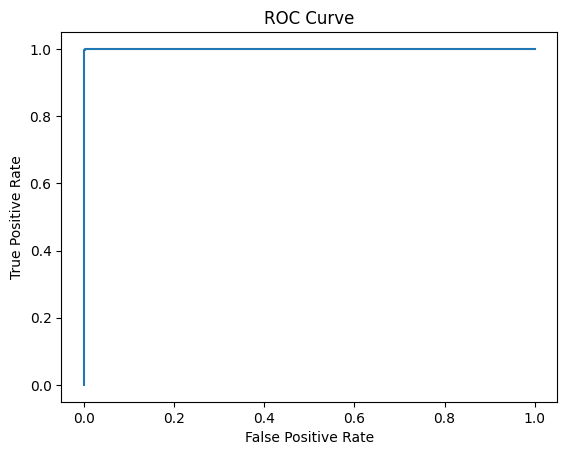

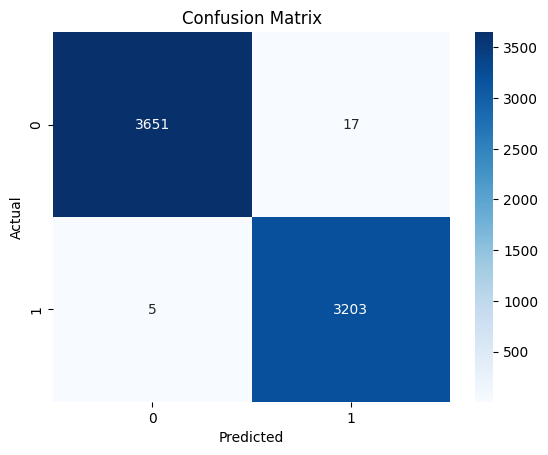

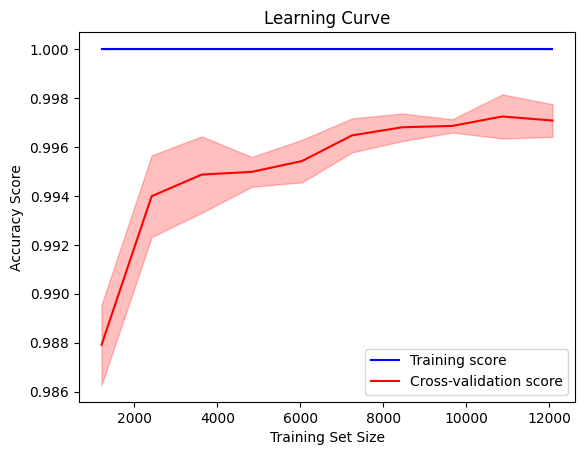

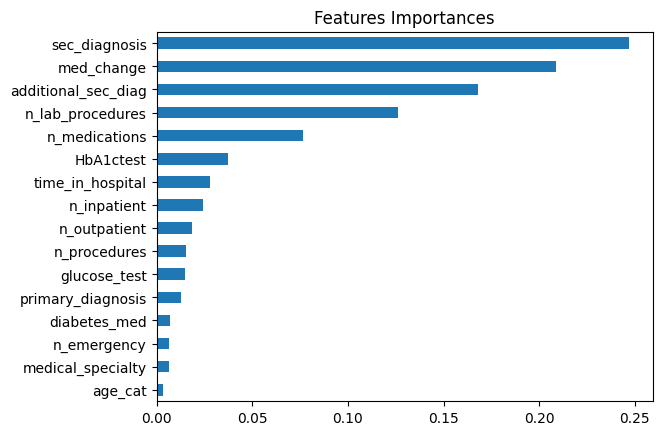

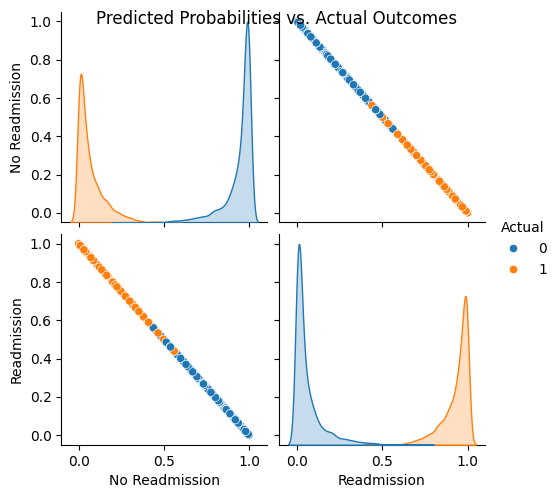

0.07096255924518906

In [122]:
from sklearn.model_selection import learning_curve
# ploting the ROC curve of the fine-tuned model
# Get the predicted probabilities

y_pred_proba = rf_rs.predict_proba(X_test)[:, 1]

# Calculate the fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Calculate the AUC-ROC score
roc_auc_score(y_test, y_pred_proba)

#plotting the confusion matrix
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#plotting the learning curve
# Create a learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_rs.best_estimator_,
    X=X_train,
    y=y_train,
    cv=3,
    train_sizes=np.linspace(0.1, 1.0, 10),
)

# Calculate the mean and standard deviation of the training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate the mean and standard deviation of the test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.fill_between(
    train_sizes, train_mean + train_std, train_mean - train_std, color="blue", alpha=0.25
)
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="red")
plt.fill_between(
    train_sizes, test_mean + test_std, test_mean - test_std, color="red", alpha=0.25
)
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")

plt.legend()
plt.show()

#plotting the feature importance
# Create a sorted Series of features importances
importances_sorted = pd.Series(
    data=rf_rs.best_estimator_.feature_importances_, index=X_train.columns
).sort_values()

# Plot a horizontal barplot of importances_sorted
importances_sorted.plot(kind="barh")
plt.title("Features Importances")
plt.show()

#plotting the data distribution
# Create a DataFrame with the predicted probabilities
df_pred = pd.DataFrame(
    data=rf_rs.predict_proba(X_test), columns=["No Readmission", "Readmission"]
)

# Create a DataFrame with the actual outcomes
df_actual = pd.DataFrame(data=y_test.values, columns=["Actual"])

# Concatenate the DataFrames
df_pred_actual = pd.concat([df_pred, df_actual], axis=1)

# Create a pairplot of the predicted probabilities and actual outcomes
sns.pairplot(df_pred_actual, hue="Actual")
plt.suptitle("Predicted Probabilities vs. Actual Outcomes")
plt.show()

#plotting the data loss
# Calculate the log loss
log_loss(y_test, rf_rs.predict_proba(X_test))



## Trying out KNN Classifier

In [123]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "n_neighbors": 20
}

# Create a logistic regression classifier object with the parameters above
knn1 = KNeighborsClassifier(**params)

# Train the classifer on the train set
knn1 = knn1.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = knn1.predict(X_test)
print('Training Set:', knn1.score(X_train,y_train))
print('Test Set:', knn1.score(X_test,y_test))

Training Set: 0.9987861399249613
Test Set: 0.9982547993019197


In [124]:
# Calculate the accuracy, precision, and recall scores
print("Accuracy:", "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred)*100))
print("Area Under the Curve:", "{:.2f}%".format(roc_auc_score(y_test, y_pred)*100))

Accuracy: 99.83%
Precision: 99.88%
Recall: 99.75%
Area Under the Curve: 99.82%


In [125]:
scores = cross_val_score(knn1, X_test, y_test, error_score="raise", cv=5, verbose=True)
scores

array([0.99636628, 0.99563636, 0.992     , 0.99272727, 0.99781818])

__OVERFIT__
#99% is overfit - This is due to using the untransformed target variable

## Feature Selection

n_lab_procedures, n_medications, n_procedures, time_in_hospital and n_inpatient are all important features in the data. This makes intuitive sense as those who spend the most time in the hospital are likely the sickest and therefore the most likely to return to the hospital. This is certainly an important takeaway from this exercise.

However, these variables are linearly associated (as shown above in the pairplot above if you run the unprocessed dataframe), meaning they often vary together and therefore describe similar variability in the data.

Since they are collinear, we should consider dropping all but the most prominent features (n_lab_procedures, n_inpatient) as signaled by the RandomForestClassifier when conducting linear regression and other linear models as we will do next.

As such, we suggest dropping 'n_medications', 'n_procedures', 'time_in_hospital' and 'n_outpatient' for linear or logistic regression.

In addition, we have a similar collinearity issue with the various diabetes indicators. We should also trim down the number of diabetes indicator variables to isolate the variability in the data due to diabetes in only 1 or two features. Therefore, we are also dropping 'glucose_test_ind', 'A1Ctest_ind'

In [126]:
#Dimensionality Reduction
#Doing dimensionality reduction so that logit model doesn't reach perfect separation

dropCols = ['n_medications', 
            'n_procedures', 
            'time_in_hospital', 
            #'n_inpatient', 
            #'n_lab_procedures',
            # 'n_emergency',
            'n_outpatient', 
            'glucose_test', 
            'HbA1ctest',
            'primary_diagnosis',
            'sec_diagnosis',
            'additional_sec_diag',
            ]

df_reduced = df_processed.copy()

for i in dropCols:
    df_reduced.drop(columns = [i], axis=1, inplace=True)

df_reduced

n_lab_procedures  n_inpatient  n_emergency  medical_specialty  \
0                 -0.17         0.25         0.20              -0.69   
1                 -0.33         0.14        -0.09              -0.12   
2                 -0.67         0.26         0.14              -0.08   
3                  0.75         1.26         0.24              -0.71   
4                  0.15        -0.16        -0.29               0.39   
...                 ...          ...          ...                ...   
24995             -1.15         2.11        -0.56               1.10   
24996             -0.02         0.69         0.64              -1.72   
24997              1.74         0.87         3.56               1.15   
24998             -0.98         0.19        -0.15               0.85   
24999             -0.78        -0.26         0.12              -0.44   

       med_change  diabetes_med  readmitted  age_cat  
0            0.11          0.54           0    -0.19  
1           -0.33         -1.08           0    -0.22  
2           -0.49          1.38           1     0.27  
3           -0.55          0.20           1     0.17  
4           -0.19         -0.80           0     0.06  
...           ...           ...         ...      ...  
24995       -0.82          1.42           1     0.53  
24996       -0.91         -0.55           1     1.35  
24997        0.52          0.71           1    -0.64  
24998       -0.35         -1.75           0    -0.30  
24999       -0.60          1.30           1     0.35  

[25000 rows x 8 columns]

In [127]:
# Split the data into two DataFrames: X (features) and y (target variable)
X = df_reduced.drop(columns=['readmitted'],axis=1)  # Specify at least one column as a feature
y = df_reduced["readmitted"]  # Specify one column as the target variable

# Split the data into train and test subsets
# You can adjust the test size and random state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18750, 7), (6250, 7), (18750,), (6250,))

## Running LogisticRegression

                   coef
n_lab_procedures   0.92
n_inpatient        0.43
n_emergency       -0.07
medical_specialty -0.11
med_change        -1.06
diabetes_med       0.02
age_cat           -0.03


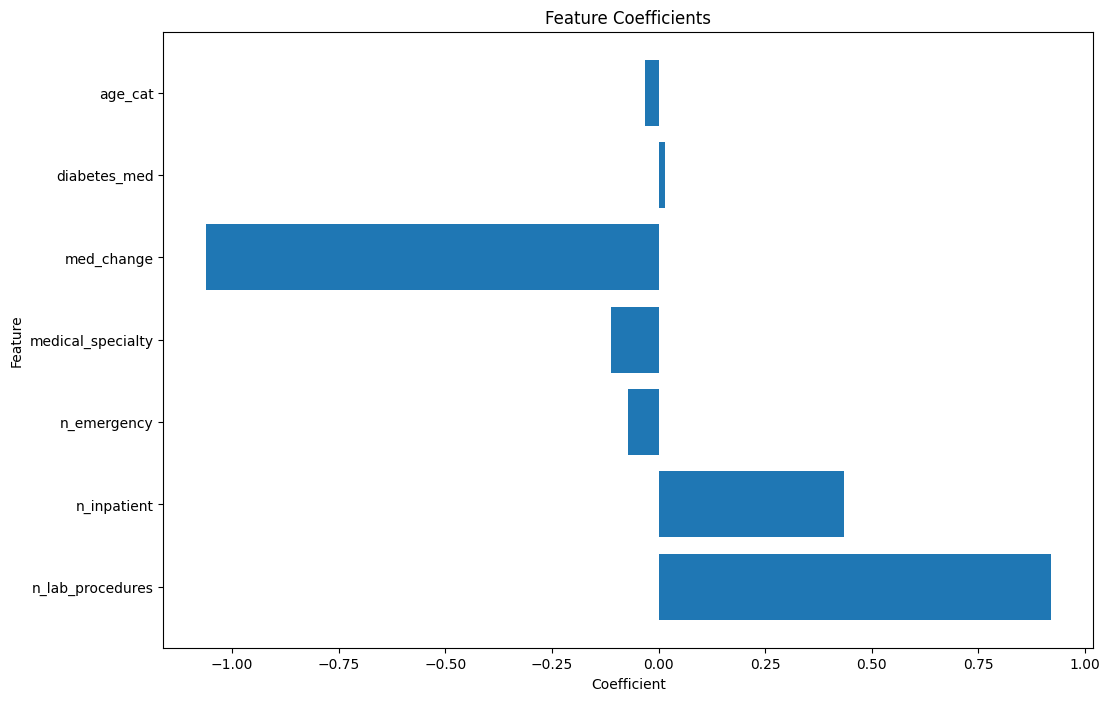

In [128]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "penalty": "l2",  # Norm of the penalty: 'l1', 'l2', 'elasticnet', 'none'
    #"C": 1,  # Inverse of regularization strength, a positive float
    "random_state": 123,
}

# Create a logistic regression classifier object with the parameters above
clf = LogisticRegression(**params)

# Train the classifer on the train set
clf = clf.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = clf.predict(X_test)
df_coef = pd.DataFrame(data=clf.coef_[0])

df_coef = df_coef.set_index(np.array(clf.feature_names_in_))
df_coef.rename(columns={0: 'coef'},inplace=True)
df_coef.sort_values('coef')

print(df_coef)

# Graph of the coefficients
plt.figure(figsize=(12, 8))
plt.barh(df_coef.index, df_coef['coef'])
plt.title('Feature Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()


In [129]:
print('Training Set:', clf.score(X_train,y_train))
print('Test Set:', clf.score(X_test,y_test))


Training Set: 0.7453866666666666
Test Set: 0.74736


In [130]:
# Calculate the accuracy, precision, and recall scores
print("Accuracy:", "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred)*100))
print("Area Under the Curve:", "{:.2f}%".format(roc_auc_score(y_test, y_pred)*100))


Accuracy: 74.74%
Precision: 74.94%
Recall: 69.28%
Area Under the Curve: 74.42%


Text(0.5, 23.52222222222222, 'Predicted label')

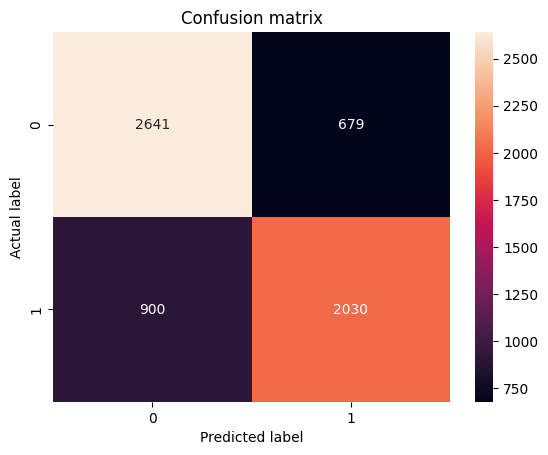

In [131]:
# Calculate confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot a labeled confusion matrix with Seaborn
sns.heatmap(cnf_matrix, annot=True, fmt="g")
plt.title("Confusion matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

## Running the Neural Network Model

In [132]:


# Ensure X_train and y_train are NumPy arrays of type float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# Initialize the Sequential model
tensor_model = keras.Sequential()

# Add the input layer
tensor_model.add(layers.InputLayer(shape=(X_train.shape[1],)))

# Add the hidden layers
tensor_model.add(layers.Dense(64, activation='relu'))
tensor_model.add(layers.Dense(64, activation='relu'))
tensor_model.add(layers.Dense(64, activation='relu'))

# Add the output layer
tensor_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
tensor_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
tensor_model.summary()

# Train the model
history = tensor_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



# Evaluate the model
_, accuracy = tensor_model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

# Predict
y_pred = tensor_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Model": ["Neural Network"],
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "AUC-ROC": [auc_roc]
})
metrics_df


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,897 (34.75 KB)

 Trainable params: 8,897 (34.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7387 - loss: 0.5364 - val_accuracy: 0.8301 - val_loss: 0.4119
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8402 - loss: 0.3786 - val_accuracy: 0.8400 - val_loss: 0.3661
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8504 - loss: 0.3429 - val_accuracy: 0.8432 - val_loss: 0.3402
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8589 - loss: 0.3117 - val_accuracy: 0.8507 - val_loss: 0.3254
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8603 - loss: 0.3002 - val_accuracy: 0.8517 - val_loss: 0.3142
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8658 - loss: 0.2932 - val_accuracy: 0.8509 - val_loss: 0.3076
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8723 - loss: 0.2795 - val_accuracy: 0.8573 - val_loss: 0.3005
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8769 - loss: 0.2669 - val_accuracy: 0.

Model  Accuracy  Precision  Recall  AUC-ROC
0  Neural Network      0.88       0.89    0.84     0.87

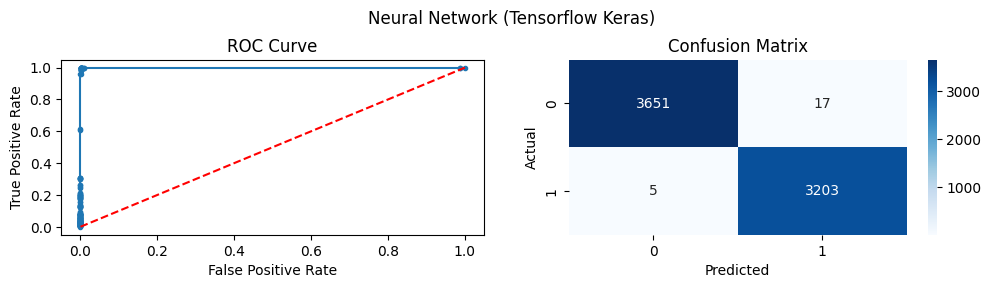

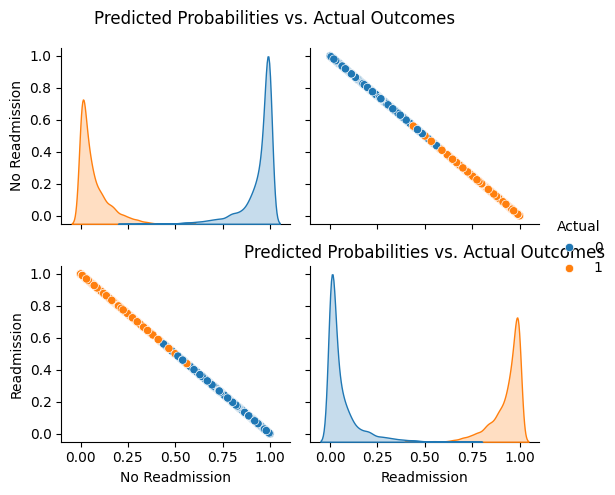

In [133]:
# Create a figure and subplots
fig = plt.figure(figsize=(12, 5))

# Set the title of the figure
fig.suptitle("Neural Network (Tensorflow Keras)")

auc_score = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# Plot the confusion matrix
plt.subplot(2, 2, 2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.subplot(2,2,1)
sns.pairplot(df_pred_actual, hue="Actual")
plt.suptitle("Predicted Probabilities vs. Actual Outcomes")
plt.title("Predicted Probabilities vs. Actual Outcomes")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()


## Running with SVC

In [134]:
# Model testing with SVC


# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "C": 1,  # Penalty parameter C of the error term
    "kernel": "rbf",  # Specifies the kernel type to be used in the algorithm
    "gamma": "scale",  # Kernel coefficient
    "random_state": 123,
}

# Create a support vector classifier object with the parameters above
svc = SVC(**params)

# Train the classifer on the train set
svc = svc.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = svc.predict(X_test)
print('Training Set:', svc.score(X_train,y_train))
print('Test Set:', svc.score(X_test,y_test))

# Calculate the accuracy, precision, and recall scores
print("Accuracy:", "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred)*100))
print("Area Under the Curve:", "{:.2f}%".format(roc_auc_score(y_test, y_pred)*100))

scores = cross_val_score(svc, X_test, y_test, error_score="raise", cv=5, verbose=True)
scores

Training Set: 0.8530133333333333
Test Set: 0.84256
Accuracy: 84.26%
Precision: 84.92%
Recall: 80.75%
Area Under the Curve: 84.05%


array([0.8328, 0.836 , 0.8296, 0.8224, 0.8296])

## Model Testing with LazyPredict
Identifying best performing models for future investigation

In [135]:
# import lazyclassifier
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=cohen_kappa_score,
                     predictions=False,
                     random_state=42,
                     classifiers = "all"
                     )

models_class, predictions_class = clf.fit(X_train , X_test , y_train , y_test)
models_class.sort_values(by='Accuracy', ascending=False,)

 97%|█████████▋| 30/31 [03:54<00:02,  2.91s/it]

[LightGBM] [Info] Number of positive: 8824, number of negative: 9926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 18750, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470613 -> initscore=-0.117682
[LightGBM] [Info] Start training from score -0.117682


100%|██████████| 31/31 [03:55<00:00,  7.59s/it]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.87               0.87     0.87      0.87   
LGBMClassifier                     0.87               0.87     0.87      0.87   
RandomForestClassifier             0.87               0.86     0.86      0.87   
ExtraTreesClassifier               0.87               0.86     0.86      0.86   
BaggingClassifier                  0.85               0.85     0.85      0.85   
KNeighborsClassifier               0.84               0.84     0.84      0.84   
SVC                                0.84               0.84     0.84      0.84   
NuSVC                              0.83               0.83     0.83      0.83   
LabelSpreading                     0.82               0.82     0.82      0.82   
LabelPropagation                   0.82               0.82     0.82      0.82   
DecisionTreeClassifier             0.82               0.82     0.82      0.82   
AdaBoostClassifier                 0.81               0.81     0.81      0.81   
CalibratedClassifierCV             0.75               0.75     0.75      0.75   
LinearSVC                          0.75               0.74     0.74      0.75   
LogisticRegression                 0.75               0.74     0.74      0.75   
SGDClassifier                      0.75               0.74     0.74      0.75   
NearestCentroid                    0.74               0.74     0.74      0.74   
QuadraticDiscriminantAnalysis      0.74               0.74     0.74      0.74   
LinearDiscriminantAnalysis         0.74               0.74     0.74      0.74   
RidgeClassifier                    0.74               0.74     0.74      0.74   
RidgeClassifierCV                  0.74               0.74     0.74      0.74   
GaussianNB                         0.74               0.74     0.74      0.74   
ExtraTreeClassifier                0.73               0.73     0.73      0.73   
PassiveAggressiveClassifier        0.69               0.69     0.69      0.69   
BernoulliNB                        0.69               0.68     0.68      0.68   
Perceptron                         0.60               0.59     0.59      0.58   
DummyClassifier                    0.53               0.50     0.50      0.37   

                               cohen_kappa_score  Time Taken  
Model                                                         
XGBClassifier                               0.74        0.43  
LGBMClassifier                              0.74        0.30  
RandomForestClassifier                      0.73        5.86  
ExtraTreesClassifier                        0.73        2.53  
BaggingClassifier                           0.70        2.17  
KNeighborsClassifier                        0.68        0.70  
SVC                                         0.68       14.10  
NuSVC                                       0.66       25.70  
LabelSpreading                              0.64      141.95  
LabelPropagation                            0.64       37.14  
DecisionTreeClassifier                      0.64        0.37  
AdaBoostClassifier                          0.62        2.15  
CalibratedClassifierCV                      0.49        0.28  
LinearSVC                                   0.49        0.11  
LogisticRegression                          0.49        0.11  
SGDClassifier                               0.49        0.07  
NearestCentroid                             0.48        0.06  
QuadraticDiscriminantAnalysis               0.48        0.07  
LinearDiscriminantAnalysis                  0.48        0.17  
RidgeClassifier                             0.48        0.04  
RidgeClassifierCV                           0.48        0.05  
GaussianNB                                  0.48        0.07  
ExtraTreeClassifier                         0.46        0.06  
PassiveAggressiveClassifier                 0.37        0.28  
BernoulliNB                                

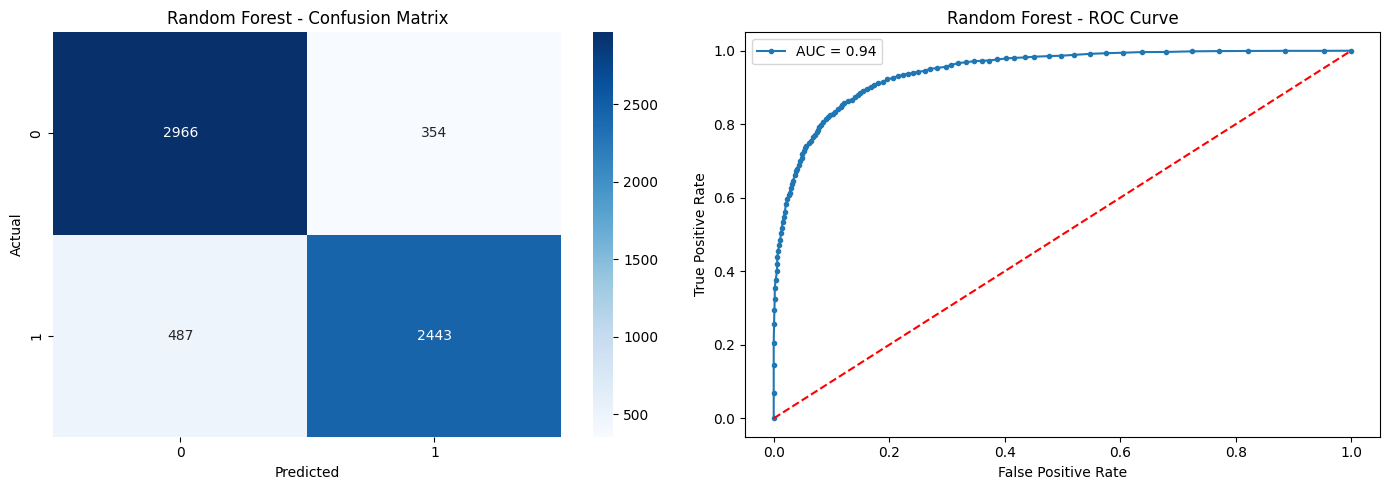

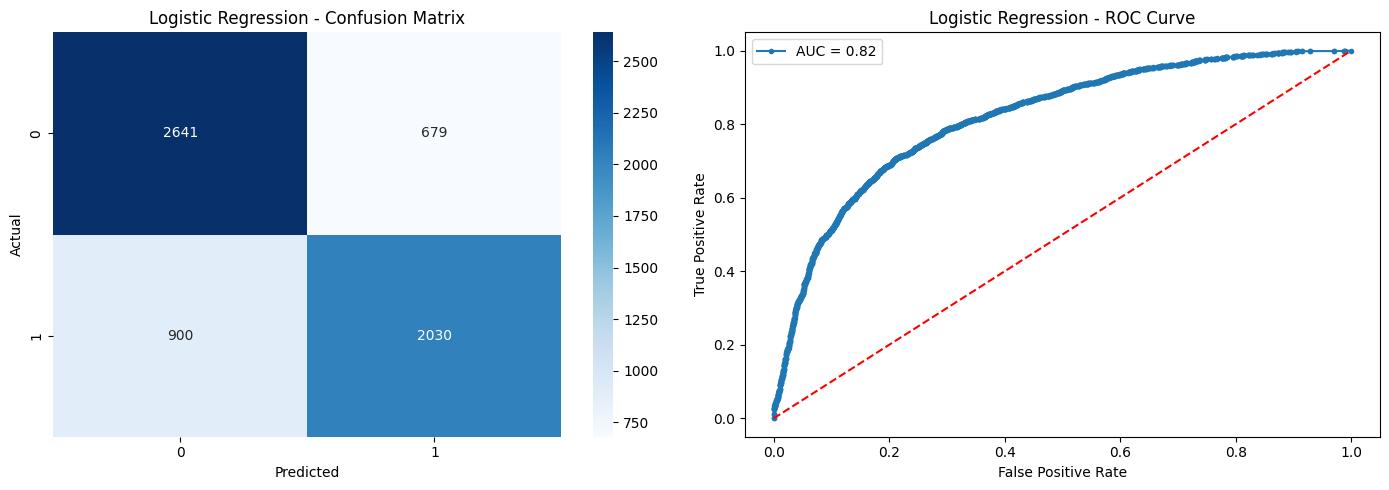

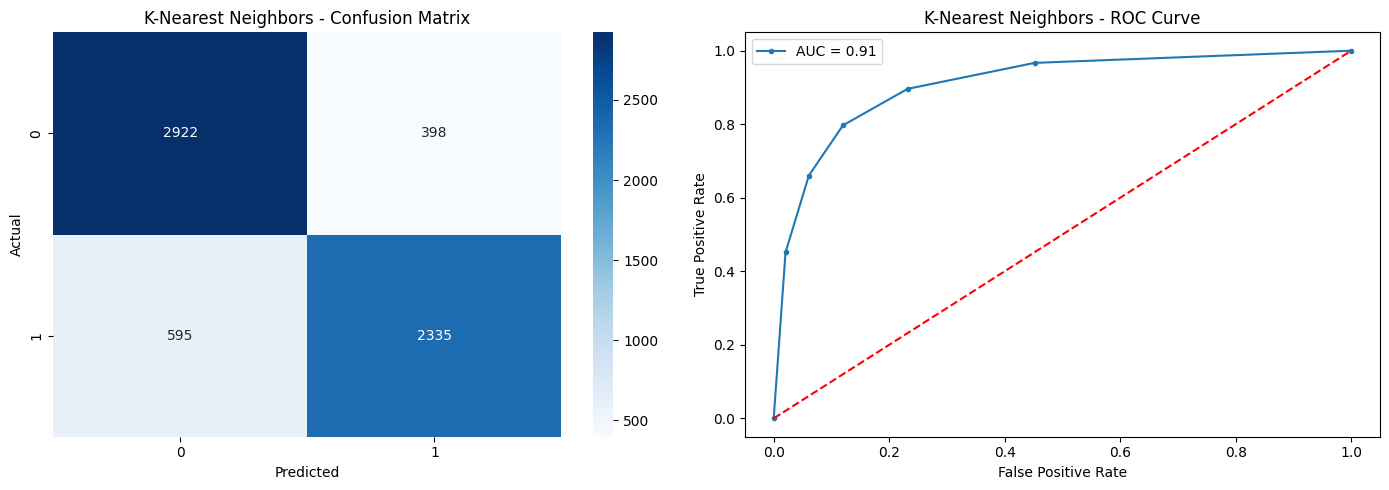

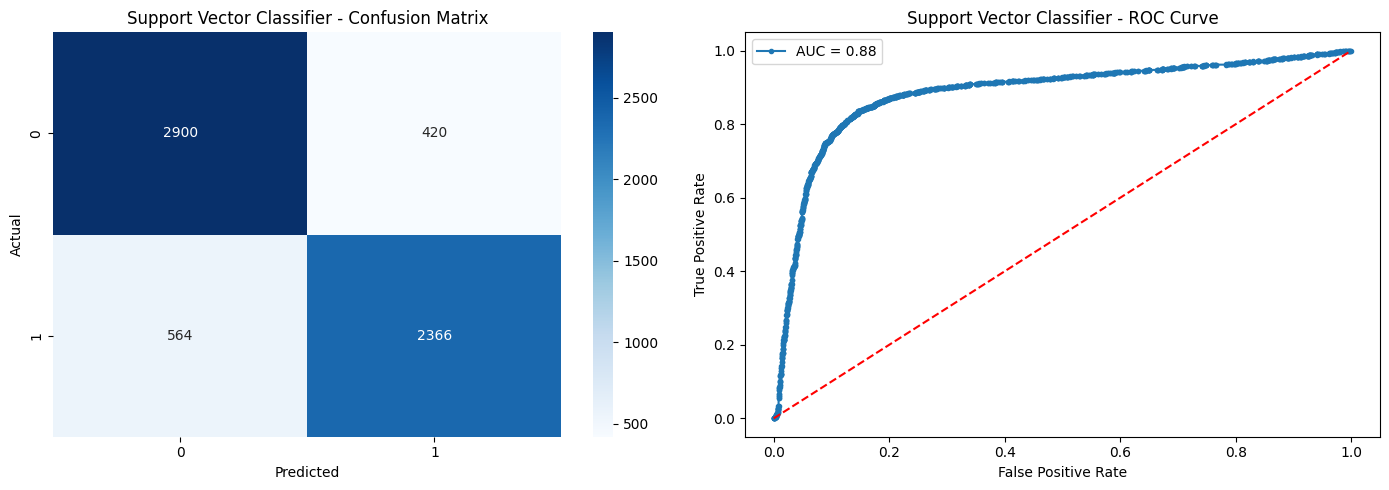

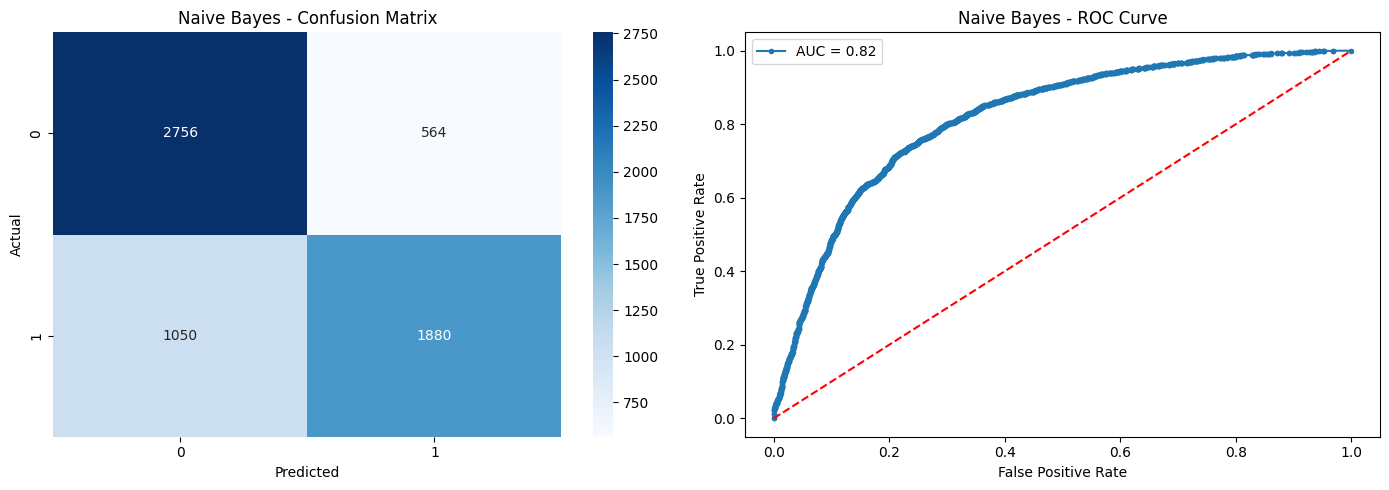

In [136]:


# Define a function to plot ROC curve and Confusion Matrix
def plot_model_performance(model, model_name, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict probabilities and classes
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # For ROC curve
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.title(f'{model_name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Select top models from LazyClassifier results


# RandomForest
model_RandomForestClassifier = RandomForestClassifier(n_estimators=100, random_state=42)
plot_model_performance(model_RandomForestClassifier, "Random Forest", X_train, y_train, X_test, y_test)

# Logistic Regression
model_Logistic_Regression = LogisticRegression(max_iter=1000)
plot_model_performance(model_Logistic_Regression, "Logistic Regression", X_train, y_train, X_test, y_test)

# K-Nearest Neighbors
model_K_nearest = KNeighborsClassifier(n_neighbors=5)
plot_model_performance(model_K_nearest, "K-Nearest Neighbors", X_train, y_train, X_test, y_test)

# Support Vector Classifier
model_svc = SVC(probability=True)
plot_model_performance(model_svc, "Support Vector Classifier", X_train, y_train, X_test, y_test)

# Naive Bayes
model_naive_bayes = GaussianNB()
plot_model_performance(model_naive_bayes, "Naive Bayes", X_train, y_train, X_test, y_test)

## Cross Validation on the Models

In [137]:
# RUnning a k-fold cross validation on the Random Forest model
# modelname = 'Random Forest'
#import RepeatedStratifiedKFold
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the cross-validation
# 5 folds, 3 repeats
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Cross-validation scores
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# Report the cross-validation score
print(f'Model: Random Forest')
print(f'Mean Accuracy: {mean(scores):.2f}')
print(f'Scores: {scores}')
# Precision, Recall, F1 Score, and Support
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, f1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {fscore}')
print(f'Support: {support}')




Model: Random Forest
Mean Accuracy: 0.87
Scores: [0.8724 0.8646 0.8722 0.87   0.8656 0.869  0.8704 0.861  0.8732 0.8688
 0.8694 0.864  0.8676 0.8668 0.8732]
Precision: [0.83718245 0.84924623]
Recall: [0.87349398 0.80750853]
F1 Score: [0.85495283 0.82785164]
Support: [3320 2930]


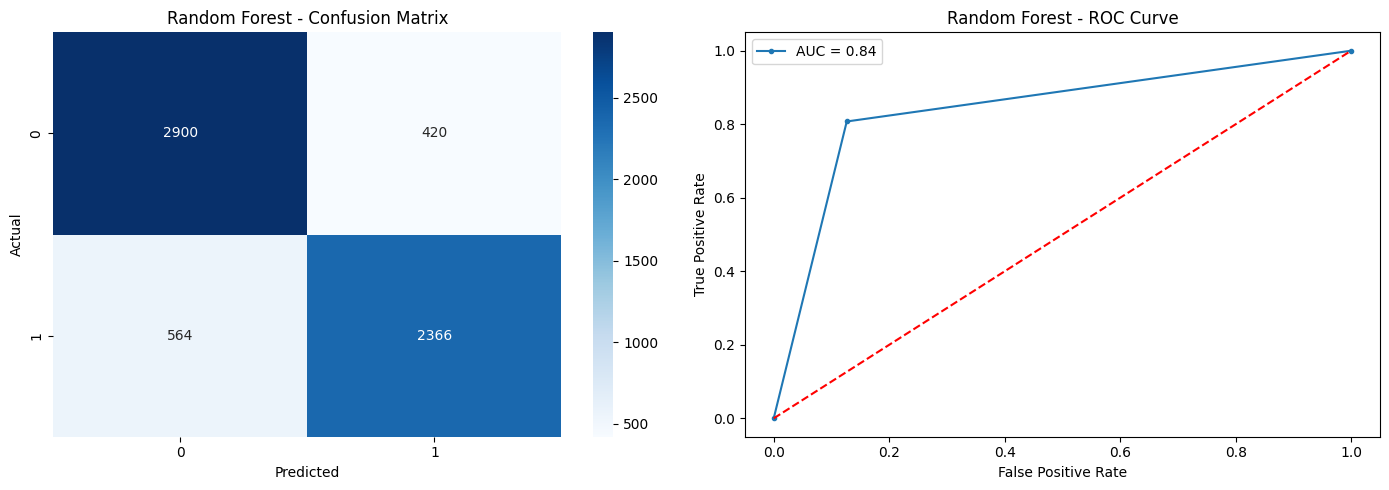

In [138]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title(f'Random Forest - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()

Model: Logistic Regression
Mean Accuracy: 0.75
Scores: [0.742  0.7494 0.7458 0.7424 0.746  0.7468 0.7396 0.7392 0.7498 0.752
 0.7442 0.7464 0.7406 0.7404 0.7506]
Precision: [0.83718245 0.84924623]
Recall: [0.87349398 0.80750853]
F1 Score: [0.85495283 0.82785164]
Support: [3320 2930]


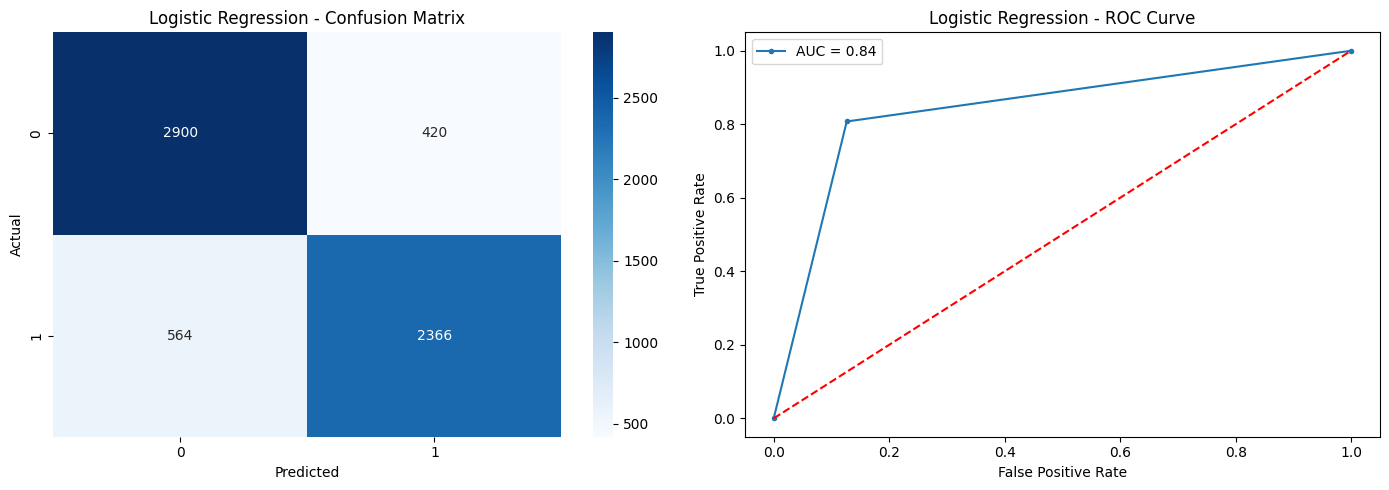

In [139]:
# Cross-validation scores for the Logistic Regression model
# Define the model
model = LogisticRegression(max_iter=1000)

# Define the cross-validation
# 5 folds, 3 repeats
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Cross-validation scores
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# Report the cross-validation score
print(f'Model: Logistic Regression')
print(f'Mean Accuracy: {mean(scores):.2f}')
print(f'Scores: {scores}')

# Precision, Recall, F1 Score, and Support
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, f1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {fscore}')
print(f'Support: {support}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title(f'Logistic Regression - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [140]:
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

# Initialize the model
model = LGBMClassifier(random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")
print(f"Standard deviation of cross-validation scores: {cv_scores.std():.4f}")


[LightGBM] [Info] Number of positive: 7060, number of negative: 7940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470667 -> initscore=-0.117468
[LightGBM] [Info] Start training from score -0.117468
[LightGBM] [Info] Number of positive: 7059, number of negative: 7941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470600 -> initscore=-0.117736
[LightGB

In [141]:
# Fitting the all 3 crossvalidation models
# Fit the model cross-validation random forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Fit the model cross-validation logistic regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

# Fit the model cross-validation lightgbm
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(X_train, y_train)

# Predictions
# Predictions on the test set
y_pred_rf = model_rf.predict(X_test)
y_pred_lr = model_lr.predict(X_test)
y_pred_lgbm = model_lgbm.predict(X_test)

# Calculate the accuracy, precision, and recall scores
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, y_pred_rf)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
auc_roc_lr = roc_auc_score(y_test, y_pred_lr)

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
auc_roc_lgbm = roc_auc_score(y_test, y_pred_lgbm)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression", "LightGBM"],
    "Accuracy": [accuracy_rf, accuracy_lr, accuracy_lgbm],
    "Precision": [precision_rf, precision_lr, precision_lgbm],
    "Recall": [recall_rf, recall_lr, recall_lgbm],
    "AUC-ROC": [auc_roc_rf, auc_roc_lr, auc_roc_lgbm]
})


[LightGBM] [Info] Number of positive: 8824, number of negative: 9926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 18750, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470613 -> initscore=-0.117682
[LightGBM] [Info] Start training from score -0.117682


## Saving the Model

In [142]:
# Save the models
joblib.dump(model_RandomForestClassifier, 'Patient-Readmission-Prediction/model_RandomForestClassifier.pkl')
joblib.dump(model_Logistic_Regression, 'Patient-Readmission-Prediction/model_Logistic_Regression.pkl')
joblib.dump(model_K_nearest, 'Patient-Readmission-Prediction/model_K_nearest.pkl')
joblib.dump(model_svc, 'Patient-Readmission-Prediction/model_svc.pkl')
joblib.dump(model_naive_bayes, 'Patient-Readmission-Prediction/model_naive_bayes.pkl')

# Save TensorFlow model
tensor_model.save('Patient-Readmission-Prediction/neural_network.keras')


In [143]:
# Save the cross-validation models
joblib.dump(model_rf, 'Patient-Readmission-Prediction/model_crossval_random_forest.pkl')
joblib.dump(model_lr, 'Patient-Readmission-Prediction/model_crossval_logistic_regression.pkl')
joblib.dump(model_lgbm, 'Patient-Readmission-Prediction/model_crossval_lightgbm.pkl')

['Patient-Readmission-Prediction/model_crossval_lightgbm.pkl']

In [144]:
import joblib
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import pandas as pd

# Load the models
model_RandomForestClassifier = joblib.load('Patient-Readmission-Prediction/model_RandomForestClassifier.pkl')
model_Logistic_Regression = joblib.load('Patient-Readmission-Prediction/model_Logistic_Regression.pkl')
model_K_nearest = joblib.load('Patient-Readmission-Prediction/model_K_nearest.pkl')
model_svc = joblib.load('Patient-Readmission-Prediction/model_svc.pkl')
model_naive_bayes = joblib.load('Patient-Readmission-Prediction/model_naive_bayes.pkl')

# Load TensorFlow model
tensor_model = keras.models.load_model('Patient-Readmission-Prediction/neural_network.keras')

# Load the cross-validation models
model_rf = joblib.load('Patient-Readmission-Prediction/model_crossval_random_forest.pkl')
model_lr = joblib.load('Patient-Readmission-Prediction/model_crossval_logistic_regression.pkl')
model_lgbm = joblib.load('Patient-Readmission-Prediction/model_crossval_lightgbm.pkl')

# Predictions on the test set
y_pred_rf = model_RandomForestClassifier.predict(X_test)
y_pred_lr = model_Logistic_Regression.predict(X_test)
y_pred_knn = model_K_nearest.predict(X_test)
y_pred_svc = model_svc.predict(X_test)
y_pred_nb = model_naive_bayes.predict(X_test)
y_pred_nn = tensor_model.predict(X_test)
y_pred_rf_cv = model_rf.predict(X_test)
y_pred_lr_cv = model_lr.predict(X_test)
y_pred_lgbm_cv = model_lgbm.predict(X_test)

# Calculate the accuracy, precision, recall, and AUC-ROC scores
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, y_pred_rf)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
auc_roc_lr = roc_auc_score(y_test, y_pred_lr)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
auc_roc_knn = roc_auc_score(y_test, y_pred_knn)

accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
auc_roc_svc = roc_auc_score(y_test, y_pred_svc)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
# Convert continuous predictions to binary values
y_pred_nn_binary = (y_pred_nn > 0.5).astype(int)

# Calculate the accuracy using binary predictions
accuracy_nn = accuracy_score(y_test, y_pred_nn_binary)
precision_nn = precision_score(y_test, y_pred_nn_binary)
recall_nn = recall_score(y_test, y_pred_nn_binary)
auc_roc_nn = roc_auc_score(y_test, y_pred_nn_binary)

accuracy_rf_cv = accuracy_score(y_test, y_pred_rf_cv)
precision_rf_cv = precision_score(y_test, y_pred_rf_cv)
recall_rf_cv = recall_score(y_test, y_pred_rf_cv)
auc_roc_rf_cv = roc_auc_score(y_test, y_pred_rf_cv)

accuracy_lr_cv = accuracy_score(y_test, y_pred_lr_cv)
precision_lr_cv = precision_score(y_test, y_pred_lr_cv)
recall_lr_cv = recall_score(y_test, y_pred_lr_cv)
auc_roc_lr_cv = roc_auc_score(y_test, y_pred_lr_cv)

accuracy_lgbm_cv = accuracy_score(y_test, y_pred_lgbm_cv)
precision_lgbm_cv = precision_score(y_test, y_pred_lgbm_cv)
recall_lgbm_cv = recall_score(y_test, y_pred_lgbm_cv)
auc_roc_lgbm_cv = roc_auc_score(y_test, y_pred_lgbm_cv)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression", "K-Nearest Neighbors", "Support Vector Classifier",
              "Naive Bayes", "Neural Network", "Random Forest (Cross-Validation)", "Logistic Regression (Cross-Validation)",
              "LightGBM (Cross-Validation)"],
    "Accuracy": [accuracy_rf, accuracy_lr, accuracy_knn, accuracy_svc, accuracy_nb, accuracy_nn, accuracy_rf_cv,
                 accuracy_lr_cv, accuracy_lgbm_cv],
    "Precision": [precision_rf, precision_lr, precision_knn, precision_svc, precision_nb, precision_nn, precision_rf_cv,
                  precision_lr_cv, precision_lgbm_cv],
    "Recall": [recall_rf, recall_lr, recall_knn, recall_svc, recall_nb, recall_nn, recall_rf_cv, recall_lr_cv,
               recall_lgbm_cv],
    "AUC-ROC": [auc_roc_rf, auc_roc_lr, auc_roc_knn, auc_roc_svc, auc_roc_nb, auc_roc_nn, auc_roc_rf_cv,
                auc_roc_lr_cv, auc_roc_lgbm_cv]
})

# Display the metrics
metrics_df

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Model  Accuracy  Precision  Recall  \
0                           Random Forest      0.87       0.87    0.83   
1                     Logistic Regression      0.75       0.75    0.69   
2                     K-Nearest Neighbors      0.84       0.85    0.80   
3               Support Vector Classifier      0.84       0.85    0.81   
4                             Naive Bayes      0.74       0.77    0.64   
5                          Neural Network      0.88       0.89    0.84   
6        Random Forest (Cross-Validation)      0.87       0.87    0.83   
7  Logistic Regression (Cross-Validation)      0.75       0.75    0.69   
8             LightGBM (Cross-Validation)      0.87       0.88    0.85   

   AUC-ROC  
0     0.86  
1     0.74  
2     0.84  
3     0.84  
4     0.74  
5     0.87  
6     0.86  
7     0.74  
8     0.87

In [ ]:
# Save the metrics
metrics_df.to_csv('metrics.csv', index=False)

#If you want to save the metrics in the Patient-Readmission-Prediction/metrics folder, you can use the following code:
if not os.path.exists('Patient-Readmission-Prediction/metrics'):
    os.makedirs('Patient-Readmission-Prediction/metrics')

# A Copy of the metrics in Patient-Readmission-Prediction folder
metrics_df.to_csv('Patient-Readmission-Prediction/metrics/metrics.csv', index=False)

In [146]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Assuming y_train and X_train are defined and contain the training data and labels

# Predictions on the training set
y_pred_rf_train = model_RandomForestClassifier.predict(X_train)
y_pred_lr_train = model_Logistic_Regression.predict(X_train)
y_pred_knn_train = model_K_nearest.predict(X_train)
y_pred_svc_train = model_svc.predict(X_train)
y_pred_nb_train = model_naive_bayes.predict(X_train)
y_pred_nn_train = tensor_model.predict(X_train)
y_pred_nn_train_binary = (y_pred_nn_train > 0.5).astype(int)
y_pred_rf_cv_train = model_rf.predict(X_train)
y_pred_lr_cv_train = model_lr.predict(X_train)
y_pred_lgbm_cv_train = model_lgbm.predict(X_train)

# Calculate the accuracy, precision, recall, and AUC-ROC scores on the training set
metrics_train = {
    "Random Forest": [accuracy_score(y_train, y_pred_rf_train), precision_score(y_train, y_pred_rf_train), recall_score(y_train, y_pred_rf_train), roc_auc_score(y_train, y_pred_rf_train)],
    "Logistic Regression": [accuracy_score(y_train, y_pred_lr_train), precision_score(y_train, y_pred_lr_train), recall_score(y_train, y_pred_lr_train), roc_auc_score(y_train, y_pred_lr_train)],
    "K-Nearest Neighbors": [accuracy_score(y_train, y_pred_knn_train), precision_score(y_train, y_pred_knn_train), recall_score(y_train, y_pred_knn_train), roc_auc_score(y_train, y_pred_knn_train)],
    "Support Vector Classifier": [accuracy_score(y_train, y_pred_svc_train), precision_score(y_train, y_pred_svc_train), recall_score(y_train, y_pred_svc_train), roc_auc_score(y_train, y_pred_svc_train)],
    "Naive Bayes": [accuracy_score(y_train, y_pred_nb_train), precision_score(y_train, y_pred_nb_train), recall_score(y_train, y_pred_nb_train), roc_auc_score(y_train, y_pred_nb_train)],
    "Neural Network": [accuracy_score(y_train, y_pred_nn_train_binary), precision_score(y_train, y_pred_nn_train_binary), recall_score(y_train, y_pred_nn_train_binary), roc_auc_score(y_train, y_pred_nn_train_binary)],
    "Random Forest (Cross-Validation)": [accuracy_score(y_train, y_pred_rf_cv_train), precision_score(y_train, y_pred_rf_cv_train), recall_score(y_train, y_pred_rf_cv_train), roc_auc_score(y_train, y_pred_rf_cv_train)],
    "Logistic Regression (Cross-Validation)": [accuracy_score(y_train, y_pred_lr_cv_train), precision_score(y_train, y_pred_lr_cv_train), recall_score(y_train, y_pred_lr_cv_train), roc_auc_score(y_train, y_pred_lr_cv_train)],
    "LightGBM (Cross-Validation)": [accuracy_score(y_train, y_pred_lgbm_cv_train), precision_score(y_train, y_pred_lgbm_cv_train), recall_score(y_train, y_pred_lgbm_cv_train), roc_auc_score(y_train, y_pred_lgbm_cv_train)]
}

# Compare training and test metrics
for model in metrics_train.keys():
    print(f"Model: {model}")
    print(f"Training Accuracy: {metrics_train[model][0]}, Test Accuracy: {metrics_df.loc[metrics_df['Model'] == model, 'Accuracy'].values[0]}")
    print(f"Training Precision: {metrics_train[model][1]}, Test Precision: {metrics_df.loc[metrics_df['Model'] == model, 'Precision'].values[0]}")
    print(f"Training Recall: {metrics_train[model][2]}, Test Recall: {metrics_df.loc[metrics_df['Model'] == model, 'Recall'].values[0]}")
    print(f"Training AUC-ROC: {metrics_train[model][3]}, Test AUC-ROC: {metrics_df.loc[metrics_df['Model'] == model, 'AUC-ROC'].values[0]}")
    print("\n")

586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Model: Random Forest
Training Accuracy: 1.0, Test Accuracy: 0.86544
Training Precision: 1.0, Test Precision: 0.8734358240972471
Training Recall: 1.0, Test Recall: 0.8337883959044369
Training AUC-ROC: 1.0, Test AUC-ROC: 0.8635809449401703


Model: Logistic Regression
Training Accuracy: 0.7453866666666666, Test Accuracy: 0.74736
Training Precision: 0.7449201741654572, Test Precision: 0.7493540051679587
Training Recall: 0.6979827742520399, Test Recall: 0.6928327645051194
Training AUC-ROC: 0.7427552396345833, Test AUC-ROC: 0.7441573461079813


Model: K-Nearest Neighbors
Training Accuracy: 0.8901866666666667, Test Accuracy: 0.84112
Training Precision: 0.9005328596802842, Test Precision: 0.8543724844493231
Training Recall: 0.8618540344514959, Test Recall: 0.7969283276450512
Training AUC-ROC: 0.8886139001594574, Test AUC-ROC: 0.838524404786381


Model: Support Vector Classifier
Training Accuracy: 0.8530133333333333, Test Accuracy: 0.84256
Training Prec

In [147]:
# Save the training metrics
metrics_train_df = pd.DataFrame(metrics_train)
metrics_train_df.to_csv('metrics_train.csv', index=False)

# A Copy of the metrics in Patient-Readmission-Prediction folder
metrics_train_df.to_csv('Patient-Readmission-Prediction/metrics/metrics_train.csv', index=False)

In [150]:
import json

# Define the model architectures
model_architectures = {
    "random_forest": "RandomForestClassifier",
    "logistic_regression": "LogisticRegression",
    "k_nearest": "KNeighborsClassifier",
    "svc": "SVC",
    "naive_bayes": "MultinomialNB",
    "neural_network": "NeuralNetwork",
    "cross_validation_random_forest": "RandomForestClassifier",
    "cross_validation_logistic_regression": "LogisticRegression",
    "cross_validation_lightgbm": "LGBMClassifier"
}

# Define the model paths
model_paths = {
    # Model paths for the models
    # /Patient-Readmission-Prediction/
    "random_forest": "model_RandomForestClassifier.pkl",
    "logistic_regression": "model_Logistic_Regression.pkl",
    "k_nearest": "model_K_nearest.pkl",
    "svc": "model_svc.pkl",
    "naive_bayes": "model_naive_bayes.pkl",
    "neural_network": "neural_network.keras",
    "cross_validation_random_forest": "model_rf.pkl",
    "cross_validation_logistic_regression": "model_lr.pkl",
    "cross_validation_lightgbm": "model_lgbm.pkl"
}

# Define the model classes
model_classes = {
    "random_forest": "RandomForestClassifier",
    "logistic_regression": "LogisticRegression",
    "k_nearest": "KNeighborsClassifier",
    "svc": "SVC",
    "naive_bayes": "MultinomialNB",
    "neural_network": "NeuralNetwork",
    "cross_validation_random_forest": "RandomForestClassifier",
    "cross_validation_logistic_regression": "LogisticRegression",
}

# Define the model configurations
model_configs = {
    "random_forest": {"n_estimators": 100, "max_depth": 5},
    "logistic_regression": {"C": 1.0, "max_iter": 1000},
    "k_nearest": {"n_neighbors": 5},
    "svc": {"C": 1.0, "kernel": "linear"},
    "naive_bayes": {"alpha": 1.0},
    "neural_network": {"input_dim": 10, "output_dim": 1, "hidden_dim": 10},
    "cross_validation_random_forest": {"n_estimators": 100, "max_depth": 5},
    "cross_validation_logistic_regression": {"C": 1.0, "max_iter": 1000},
    "cross_validation_lightgbm": {"random_state": 42}
}

# Library used to create the model
model_library = {
    "random_forest": "scikit-learn",
    "logistic_regression": "scikit-learn",
    "k_nearest": "scikit-learn",
    "svc": "scikit-learn",
    "naive_bayes": "scikit-learn",
    "neural_network": "keras",
    "cross_validation_random_forest": "scikit-learn",
    "cross_validation_logistic_regression": "scikit-learn",
    "cross_validation_lightgbm": "LightGBM"
}

# Create the Hugging Face model hub
model_hub = {
    "model_id": "prabinpanta0/Patient-Readmission-Prediction",
    "model_type": "sequence-classification",
    # Library used to create the model
    "library": model_library, # scikit-learn, keras, TensorFlow, LightGBM, PyTorch, Hugging Face
    "model_architectures": model_architectures,
    "model_paths": model_paths,
    "model_classes": model_classes,
    "model_configs": model_configs
}

# Save the model hub to a file
with open("Patient-Readmission-Prediction/model_hub.json", "w") as f:
    json.dump(model_hub, f)